In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt

# sorgt dafür, dass Plots im Notebook angezeigt werden
%matplotlib inline

# Lesbarkeit in der Exploration erhöhen
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 140)

In [2]:
# Projekt- & BigQuery-Konfiguration
PROJECT_ID = "taxi-bi-project"
DATASET_ID = "staging"
BQ_LOCATION = "EU"

# Vollständiges Dataset-Prefix, z.B. "taxi-bi-project.staging"
FULL_DATASET_PREFIX = f"{PROJECT_ID}.{DATASET_ID}"

# BigQuery Client initialisieren
bq_client = bigquery.Client(
    project=PROJECT_ID,
    location=BQ_LOCATION
)

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
# Damit mein Code unten 1:1 funktioniert:
client = bq_client

# Green View (Name wie in exploration_overview)
GREEN_VIEW = "green_staging_unified"

# Vollqualifizierter Tabellenname
GREEN_TABLE = f"`{FULL_DATASET_PREFIX}.{GREEN_VIEW}`"

GREEN_TABLE

'`taxi-bi-project.staging.green_staging_unified`'

In [4]:
def get_columns(client: bigquery.Client, full_table_id: str) -> dict:
    full_table_id = full_table_id.strip("`")
    project, dataset, table = full_table_id.split(".")
    sql = f"""
    SELECT column_name, data_type
    FROM `{project}.{dataset}.INFORMATION_SCHEMA.COLUMNS`
    WHERE table_name = '{table}'
    """
    df = client.query(sql).to_dataframe()
    return dict(zip(df["column_name"], df["data_type"]))

cols = get_columns(client, GREEN_TABLE)

def has_col(name: str) -> bool:
    return name in cols

# typische Green-Spalten (nur setzen, wenn sie existieren)
PICKUP_COL  = "lpep_pickup_datetime" if has_col("lpep_pickup_datetime") else None
DROPOFF_COL = "lpep_dropoff_datetime" if has_col("lpep_dropoff_datetime") else None

cols, PICKUP_COL, DROPOFF_COL

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


({'VendorID': 'INT64',
  'lpep_pickup_datetime': 'DATETIME',
  'lpep_dropoff_datetime': 'DATETIME',
  'store_and_fwd_flag': 'STRING',
  'RatecodeID': 'INT64',
  'PULocationID': 'INT64',
  'DOLocationID': 'INT64',
  'passenger_count': 'INT64',
  'trip_distance': 'FLOAT64',
  'fare_amount': 'FLOAT64',
  'extra': 'FLOAT64',
  'mta_tax': 'FLOAT64',
  'tip_amount': 'FLOAT64',
  'tolls_amount': 'FLOAT64',
  'ehail_fee': 'FLOAT64',
  'improvement_surcharge': 'FLOAT64',
  'total_amount': 'FLOAT64',
  'payment_type': 'INT64',
  'trip_type': 'INT64',
  'congestion_surcharge': 'FLOAT64',
  'duplicate_flag': 'STRING',
  'missing_flag': 'STRING'},
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime')

# Übersicht über die numerischen Spalten

In [5]:
# nur numerische Spalten
NUM_COLS = [
    "trip_distance", "fare_amount",
    "extra", "mta_tax", "tip_amount", "tolls_amount",
    "ehail_fee", "improvement_surcharge", "total_amount", "congestion_surcharge"
]

# duration_min kommt aus DATETIME_DIFF, ist keine echte Spalte
def bq_full_describe_as_pandas_like(table: str, num_cols: list[str],
                                   pickup_col: str, dropoff_col: str) -> pd.DataFrame:
    select_parts = []

    # Helper für Quantile
    def q(expr: str, p: int) -> str:
        return f"APPROX_QUANTILES({expr}, 100)[OFFSET({p})]"

    # Pro numerischer Spalte bauen wir eine kleine Struct mit allen Kennzahlen
    for c in num_cols:
        select_parts.append(f"""
        STRUCT(
          '{c}' AS metric,
          COUNT({c}) AS count,
          AVG({c}) AS mean,
          STDDEV({c}) AS std,
          MIN({c}) AS min,
          {q(c,25)} AS p25,
          {q(c,50)} AS p50,
          {q(c,75)} AS p75,
          MAX({c}) AS max
        ) AS s_{c}
        """)

    # duration_min als virtuelle Kennzahl
    dur_expr = f"DATETIME_DIFF({dropoff_col}, {pickup_col}, SECOND) / 60.0"
    select_parts.append(f"""
    STRUCT(
      'duration_min' AS metric,
      COUNT({dur_expr}) AS count,
      AVG({dur_expr}) AS mean,
      STDDEV({dur_expr}) AS std,
      MIN({dur_expr}) AS min,
      {q(dur_expr,25)} AS p25,
      {q(dur_expr,50)} AS p50,
      {q(dur_expr,75)} AS p75,
      MAX({dur_expr}) AS max
    ) AS s_duration_min
    """)

    query = f"""
    SELECT
      {", ".join(select_parts)}
    FROM {table}
    """

    wide = client.query(query).to_dataframe()

    # Wir machen aus den vielen Struct-Spalten eine lange Tabelle (metric, stat, value)
    records = []
    for col in wide.columns:
        s = wide.loc[0, col] 
        metric = s["metric"]
        for stat in ["count", "mean", "std", "min", "p25", "p50", "p75", "max"]:
            records.append({"stat": stat, "metric": metric, "value": s[stat]})

    long = pd.DataFrame(records)
    # Pivot in "describe"-Layout: Zeilen=stat, Spalten=metric
    out = long.pivot(index="stat", columns="metric", values="value").loc[
        ["count", "mean", "std", "min", "p25", "p50", "p75", "max"]
    ]

    return out

df_full_describe = bq_full_describe_as_pandas_like(
    table=GREEN_TABLE,
    num_cols=NUM_COLS,
    pickup_col=PICKUP_COL,
    dropoff_col=DROPOFF_COL
)

df_full_describe

metric,congestion_surcharge,duration_min,ehail_fee,extra,fare_amount,improvement_surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_distance
stat,,,,,,,,,,,
count,9.431400e+06,6.804560e+07,3052.000000,6.804560e+07,6.804560e+07,6.804560e+07,6.804560e+07,6.804560e+07,6.804560e+07,6.804560e+07,6.804560e+07
mean,5.257621e-01,2.026253e+01,0.024279,4.096599e-01,1.310420e+01,3.070685e-01,4.818590e-01,1.202202e+00,1.566005e-01,1.576422e+01,6.990576e+00
std,1.081314e+00,5.543000e+02,0.216264,5.867575e-01,1.178539e+01,1.304443e-01,1.226293e-01,2.678468e+00,1.570566e+00,1.207548e+02,6.803225e+02
min,-2.750000e+00,-5.259412e+05,0.000000,-2.542000e+01,-8.900000e+02,-1.000000e+00,-4.950000e+01,-1.010000e+02,-8.000000e+01,-8.903000e+02,-2.032908e+04
p25,0.000000e+00,6.250000e+00,0.000000,0.000000e+00,6.500000e+00,3.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,8.300000e+00,1.050000e+00
p50,0.000000e+00,1.061667e+01,0.000000,5.000000e-01,9.500000e+00,3.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,1.180000e+01,1.900000e+00
p75,0.000000e+00,1.780000e+01,0.000000,5.000000e-01,1.600000e+01,3.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.896000e+01,3.670000e+00
max,2.750000e+00,3.155398e+06,1.950000,8.300000e+01,1.044584e+04,1.770000e+00,8.291000e+01,2.017730e+03,7.999920e+03,9.899704e+05,3.600681e+05


Diese Tabelle zeigt eine Full-Data-Deskriptivstatistik im „describe“-Stil für zentrale numerische Spalten sowie die abgeleitete Fahrtdauer duration_min. Die Zeile count gibt an, wie viele Datensätze pro Spalte tatsächlich einen Wert haben (Unterschiede deuten auf Missing Values hin, z. B. bei ehail_fee). mean ist der Durchschnitt, std die Standardabweichung (hohe Werte sprechen oft für starke Streuung bzw. Ausreißer). min und max zeigen die kleinsten und größten beobachteten Werte und machen Datenqualitätsprobleme direkt sichtbar (z. B. negative Werte oder extrem große Maxima). Die Quartile p25, p50 (Median) und p75 beschreiben typische Wertebereiche: 25 % der Fahrten liegen unter p25, 50 % unter p50, 75 % unter p75. Diese Kennzahlen sind robuster gegenüber Ausreißern als der Mittelwert. Insgesamt sieht man, dass die „typischen“ Fahrten über Quartile/Median plausibel wirken, während min/max und die sehr großen Streuungen klar auf Ausreißer und fehlerhafte Einträge hinweisen, die später für eine saubere Analyse gefiltert oder gesondert behandelt werden müssen.

In [6]:
def bq_full_anomaly_rates_as_describe_like(table: str, num_cols: list[str],
                                          pickup_col: str, dropoff_col: str) -> pd.DataFrame:
    parts = []

    # Numerische Spalten (NULL / negativ / 0)
    for c in num_cols:
        parts.append(f"""
        SELECT
          '{c}' AS metric,
          COUNT(*) AS n_rows,
          SAFE_DIVIDE(SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END), COUNT(*)) AS null_rate,
          SAFE_DIVIDE(SUM(CASE WHEN {c} IS NOT NULL AND {c} < 0 THEN 1 ELSE 0 END), COUNT(*)) AS negative_rate,
          SAFE_DIVIDE(SUM(CASE WHEN {c} IS NOT NULL AND {c} = 0 THEN 1 ELSE 0 END), COUNT(*)) AS zero_rate,
          NULL AS over_24h_rate
        FROM {table}
        """)

    # duration_min aus DATETIME_DIFF (zusätzlich >24h)
    dur_min = f"DATETIME_DIFF({dropoff_col}, {pickup_col}, SECOND) / 60.0"
    parts.append(f"""
    SELECT
      'duration_min' AS metric,
      COUNT(*) AS n_rows,
      SAFE_DIVIDE(SUM(CASE WHEN {pickup_col} IS NULL OR {dropoff_col} IS NULL THEN 1 ELSE 0 END), COUNT(*)) AS null_rate,
      SAFE_DIVIDE(SUM(CASE WHEN {pickup_col} IS NOT NULL AND {dropoff_col} IS NOT NULL AND {dur_min} < 0 THEN 1 ELSE 0 END), COUNT(*)) AS negative_rate,
      SAFE_DIVIDE(SUM(CASE WHEN {pickup_col} IS NOT NULL AND {dropoff_col} IS NOT NULL AND {dur_min} = 0 THEN 1 ELSE 0 END), COUNT(*)) AS zero_rate,
      SAFE_DIVIDE(SUM(CASE WHEN {pickup_col} IS NOT NULL AND {dropoff_col} IS NOT NULL
                           AND DATETIME_DIFF({dropoff_col}, {pickup_col}, HOUR) > 24 THEN 1 ELSE 0 END), COUNT(*)) AS over_24h_rate
    FROM {table}
    """)

    query = "\nUNION ALL\n".join(parts)
    df_long = client.query(query).to_dataframe()

    # In "describe"-Layout pivotieren (Zeilen=stat, Spalten=metric)
    df_long["null_pct"] = (df_long["null_rate"] * 100).round(3)
    df_long["negative_pct"] = (df_long["negative_rate"] * 100).round(3)
    df_long["zero_pct"] = (df_long["zero_rate"] * 100).round(3)
    df_long["over_24h_pct"] = (df_long["over_24h_rate"] * 100).round(3)

    df_out = df_long.set_index("metric")[["null_pct", "negative_pct", "zero_pct", "over_24h_pct", "n_rows"]].T

    # Reihenfolge wie bei describe (erst Raten, dann n_rows)
    desired_order = ["n_rows", "null_pct", "negative_pct", "zero_pct", "over_24h_pct"]
    df_out = df_out.reindex([r for r in desired_order if r in df_out.index])

    return df_out

df_full_anomaly = bq_full_anomaly_rates_as_describe_like(
    table=GREEN_TABLE,
    num_cols=NUM_COLS,
    pickup_col=PICKUP_COL,
    dropoff_col=DROPOFF_COL
)

df_full_anomaly

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


metric,total_amount,tolls_amount,duration_min,ehail_fee,mta_tax,improvement_surcharge,extra,congestion_surcharge,tip_amount,fare_amount,trip_distance
n_rows,68045597,68045597,68045597,68045597,68045597,68045597,68045597,68045597,68045597,68045597,68045597
null_pct,0.0,0.0,0.0,99.996,0.0,0.0,0.0,86.14,0.0,0.0,0.0
negative_pct,0.217,0.0,0.003,0.0,0.2,0.192,0.108,0.0,0.003,0.217,0.029
zero_pct,0.234,97.402,0.085,0.004,3.887,3.491,48.361,11.209,59.529,0.248,1.641
over_24h_pct,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Diese Tabelle ergänzt dazu die Full-Data-Anomaliequoten im gleichen Layout, wie die vorherige Tabelle und quantifiziert, wie häufig typische Datenprobleme je Spalte auftreten. n_rows ist die Gesamtanzahl aller Datensätze im Datensatz (Basis für die Quoten). null_pct gibt den prozentualen Anteil fehlender Werte an. Hier fällt besonders ehail_fee mit nahezu vollständiger Missing Rate auf, was darauf hindeutet, dass diese Gebühr für Green Taxis in den meisten Fällen nicht erhoben oder nicht erfasst wird. negative_pct zeigt den Anteil negativer Werte und weist auf offensichtliche Inkonsistenzen oder Sonderfälle wie Korrekturen/Refunds hin (z. B. negative Beträge oder negative Distanzen). zero_pct misst den Anteil an Nullwerten, was je nach Spalte entweder normal sein kann (z. B. viele Fahrten ohne tip_amount oder ohne tolls_amount) oder auf unplausible Einträge hinweist (z. B. Distanz = 0 bei einer bezahlten Fahrt). over_24h_pct ist nur für duration_min relevant und zeigt den Anteil extrem langer Fahrten über 24 Stunden. Dass hier 0,0 % steht, ist ein gutes Zeichen, während kleine negative Anteile bei duration_min trotzdem auf fehlerhafte Zeitstempel (Dropoff vor Pickup) schließen lassen. Insgesamt macht die Tabelle transparent, welche Auffälligkeiten „nur einzelne Ausreißer“ sind und welche systematisch auftreten und daher bei der Bereinigung und späteren Dashboard-Kommunikation explizit berücksichtigt werden sollten.

# Missing-Value Analyse

In [7]:
# Missing-Rate je Spalte exakt auf dem gesamten Datensatz
# Ausgabe in % + aufgeräumter Index + zusätzliche "kritisch"-Flag

column_names = list(cols.keys())

select_parts = ["COUNT(1) AS total_rows"]

for c in column_names:
    # BigQuery: Identifier escapen (Backticks), damit auch "komische" Spaltennamen funktionieren
    select_parts.append(f"COUNTIF(`{c}` IS NULL) / COUNT(1) AS miss_share_{c}")

missing_sql = f"""
SELECT
  {", ".join(select_parts)}
FROM {GREEN_TABLE}
"""

df_missing_full = client.query(missing_sql).to_dataframe()

# Long Format
total_rows = int(df_missing_full.loc[0, "total_rows"])
miss_cols = [c for c in df_missing_full.columns if c.startswith("miss_share_")]

mv_green_full = (
    df_missing_full[miss_cols]
    .T
    .reset_index(drop=False)
    .rename(columns={"index": "column", 0: "missing_rate"})
)

mv_green_full["column"] = mv_green_full["column"].str.replace("miss_share_", "", regex=False)
mv_green_full["total_rows"] = total_rows

mv_green_full["missing_pct"] = (mv_green_full["missing_rate"] * 100).round(2)
mv_green_full["mostly_missing"] = mv_green_full["missing_rate"] >= 0.95

mv_green_full = (
    mv_green_full
    .sort_values("missing_rate", ascending=False)
    .reset_index(drop=True)
)

display(mv_green_full[["column", "missing_pct", "missing_rate", "mostly_missing", "total_rows"]].head(30))

display(
    mv_green_full["mostly_missing"].value_counts().rename_axis("mostly_missing").to_frame("count")
)

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,column,missing_pct,missing_rate,mostly_missing,total_rows
0,ehail_fee,100.00,9.999551e-01,True,68045597
1,congestion_surcharge,86.14,8.613959e-01,False,68045597
2,trip_type,2.82,2.817334e-02,False,68045597
3,store_and_fwd_flag,2.81,2.811632e-02,False,68045597
4,RatecodeID,2.81,2.811632e-02,False,68045597
5,passenger_count,2.81,2.811632e-02,False,68045597
6,payment_type,2.81,2.811632e-02,False,68045597
7,improvement_surcharge,0.00,2.939206e-08,False,68045597
8,VendorID,0.00,0.000000e+00,False,68045597
9,tolls_amount,0.00,0.000000e+00,False,68045597


,count
mostly_missing,
False,21
True,1


Die Missing-Value-Analyse zeigt zwei stark unvollständige Spalten: ehail_fee ist praktisch komplett leer (≈100%), und congestion_surcharge weist sehr viele fehlende Werte (≈86%) auf.
Alle übrigen Spalten sind nahezu vollständig (meist 0% Missing; wenige bei ca. 2–3%), sodass die Datenbasis abseits dieser beiden Felder gut für weitere Analysen geeignet ist.

In [8]:
TIME_COL = PICKUP_COL

cols_to_check = [
    "ehail_fee",
    "congestion_surcharge",
    "payment_type",   # als Vergleich
]

In [9]:
cols_sql = ",\n".join([
    f"  100 * AVG(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) AS miss_{c}"
    for c in cols_to_check
])

missing_time_sql = f"""
SELECT
  FORMAT_DATE('%Y-%m', DATE({TIME_COL})) AS month,
  COUNT(1) AS n_rows,
{cols_sql}
FROM {GREEN_TABLE}
GROUP BY month
ORDER BY month
"""
df_missing_time = client.query(missing_time_sql).to_dataframe()
df_missing_time.head()

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,month,n_rows,miss_ehail_fee,miss_congestion_surcharge,miss_payment_type
0,2008-10,1,100.0,0.000000,0.0
1,2008-12,113,100.0,72.566372,0.0
2,2009-01,315,100.0,55.238095,0.0
3,2010-09,348,100.0,85.919540,0.0
4,2012-09,3,100.0,100.000000,0.0


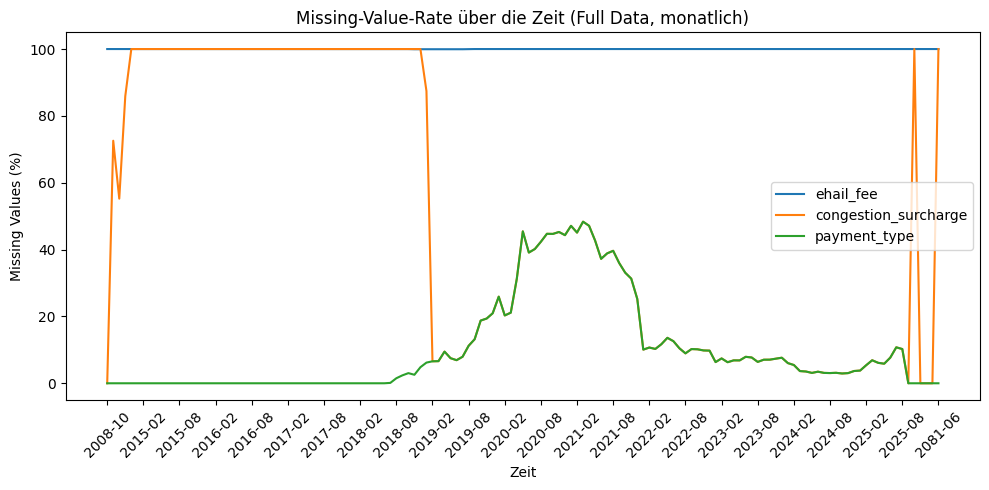

In [10]:
plt.figure(figsize=(10, 5))

for c in cols_to_check:
    plt.plot(
        df_missing_time["month"],
        df_missing_time[f"miss_{c}"],
        label=c
    )

plt.title("Missing-Value-Rate über die Zeit (Full Data, monatlich)")
plt.xlabel("Zeit")
plt.ylabel("Missing Values (%)")

xticks = df_missing_time["month"][::6]
plt.xticks(xticks, rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


Die zeitliche Analyse der Missing-Value-Raten zeigt deutlich, dass fehlende Werte nicht zufällig verteilt sind, sondern stark vom Erhebungszeitraum abhängen. Für die Spalte ehail_fee liegt über den gesamten Zeitraum hinweg eine Missing-Rate von nahezu 100 % vor, was darauf hindeutet, dass dieses Feld entweder historisch nicht befüllt wurde oder nur für sehr spezielle Fahrtarten vorgesehen ist. Die Spalte congestion_surcharge weist ebenfalls über lange Zeiträume eine vollständige Nichtbefüllung auf, fällt jedoch in späteren Zeitabschnitten abrupt auf nahezu 0 % Missing Values ab, was klar auf eine spätere Einführung oder Änderung der Datenerfassung hindeutet. Im Gegensatz dazu zeigt payment_type eine zeitlich variable Missing-Rate, mit einem deutlichen Anstieg in bestimmten Jahren und einer anschließenden Stabilisierung auf niedrigerem Niveau. Dies spricht für Anpassungen in der Datenerfassung oder Validierungslogik über die Zeit. Insgesamt belegt die Analyse, dass hohe Missing-Raten in einzelnen Spalten nicht zwingend auf schlechte Datenqualität zurückzuführen sind, sondern häufig durch strukturelle oder zeitliche Änderungen im Erhebungssystem verursacht werden. Diese Erkenntnis ist entscheidend für die korrekte Interpretation der Daten und die Ableitung geeigneter Maßnahmen in nachgelagerten Analyseschritten.

# Kategorische / Code-Spalten

In [11]:
# Kategorische / Code-Spalten – Basis-Setup
# Zur einheitlichen Exploration & Plausibilitätsprüfung

cat_cols = [
    "VendorID",
    "RatecodeID",
    "payment_type",
    "trip_type",
    "store_and_fwd_flag"
]

In [12]:
# VendorID – Verteilung
query_vendor = f"""
SELECT
  VendorID,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY VendorID
ORDER BY cnt DESC
"""
df_vendor = client.query(query_vendor).to_dataframe()
df_vendor

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,VendorID,cnt
0,2,55115469
1,1,12917357
2,6,12724
3,5,47


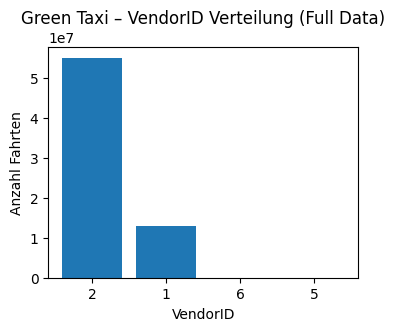

In [13]:
# VendorID – Verteilung Plot
plt.figure(figsize=(4,3))
plt.bar(df_vendor["VendorID"].astype(str), df_vendor["cnt"])
plt.title("Green Taxi – VendorID Verteilung (Full Data)")
plt.xlabel("VendorID")
plt.ylabel("Anzahl Fahrten")
plt.show()

Die Verteilung der VendorID ist extrem ungleich. Zwei Vendoren (ID 2 und 1) decken nahezu den gesamten Datensatz ab, wobei VendorID = 2 den mit Abstand größten Anteil der Fahrten stellt. Die übrigen VendorIDs (5 und 6) kommen nur in sehr geringer Anzahl vor und sind praktisch vernachlässigbar.


Die starke Dominanz einzelner VendorIDs deutet darauf hin, dass der Green-Taxi-Betrieb im betrachteten Zeitraum überwiegend von wenigen zentralen Anbietern getragen wird. Seltene VendorIDs könnten auf Sonderfälle, historische Datenreste oder Test-/Übergangsanbieter hindeuten und spielen für aggregierte Analysen kaum eine Rolle.

In [14]:
# payment_type – Verteilung
query_payment = f"""
SELECT
  payment_type,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY payment_type
ORDER BY cnt DESC
"""
df_payment = client.query(query_payment).to_dataframe()
df_payment

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,payment_type,cnt
0,1,33862955
1,2,31799574
2,<NA>,1913192
3,3,289307
4,4,177632
5,5,2937


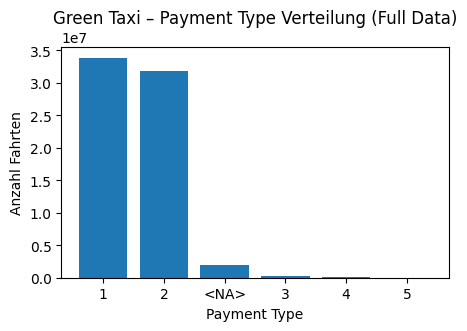

In [15]:
# payment_type – Verteilung Plot
plt.figure(figsize=(5,3))
plt.bar(df_payment["payment_type"].astype(str), df_payment["cnt"])
plt.title("Green Taxi – Payment Type Verteilung (Full Data)")
plt.xlabel("Payment Type")
plt.ylabel("Anzahl Fahrten")
plt.show()

Die Zahlungsarten im Green-Taxi-Datensatz sind stark auf wenige Codes konzentriert. Payment Type 1 und 2 dominieren den Datensatz deutlich, während andere Zahlungsarten nur einen sehr kleinen Anteil ausmachen. Auffällig ist zudem ein relevanter Anteil fehlender Werte, was auf unvollständig erfasste oder historisch unterschiedlich behandelte Zahlungsinformationen hindeutet.

In [16]:
# RatecodeID – Verteilung
query_ratecode = f"""
SELECT
  RatecodeID,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY RatecodeID
ORDER BY cnt DESC
"""
df_ratecode = client.query(query_ratecode).to_dataframe()
df_ratecode

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,RatecodeID,cnt
0,1,64197459
1,<NA>,1913192
2,5,1683422
3,2,163748
4,3,43547
5,4,41924
6,99,1195
7,6,1110


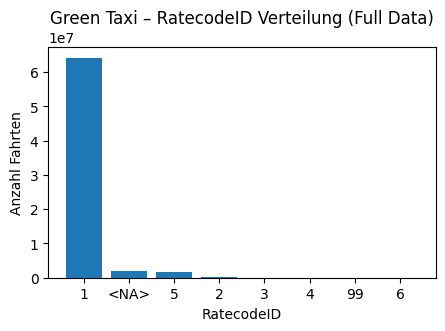

In [17]:
# RatecodeID – Verteilung Plot
plt.figure(figsize=(5,3))
plt.bar(df_ratecode["RatecodeID"].astype(str), df_ratecode["cnt"])
plt.title("Green Taxi – RatecodeID Verteilung (Full Data)")
plt.xlabel("RatecodeID")
plt.ylabel("Anzahl Fahrten")
plt.show()

Die Verteilung der RatecodeID ist stark konzentriert auf den Standard-Tarif (RatecodeID = 1), der den überwiegenden Großteil aller Fahrten abdeckt. Andere Ratecodes (z. B. Flughafen- oder Sondertarife) treten nur sehr selten auf, während ein kleiner Anteil fehlender Werte auf unvollständig übermittelte oder nicht gesetzte Tarifinformationen hinweist.Seltene Codes sowie vereinzelte Sonderwerte (z. B. 99) sollten in späteren Analysen ggf. zusammengefasst oder gesondert behandelt werden, da sie statistisch kaum Gewicht haben.

In [18]:
# trip_type – Verteilung
query_trip_type = f"""
SELECT
  trip_type,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY trip_type
ORDER BY cnt DESC
"""
df_trip_type = client.query(query_trip_type).to_dataframe()
df_trip_type

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,trip_type,cnt
0,1,64458610
1,<NA>,1917072
2,2,1669915


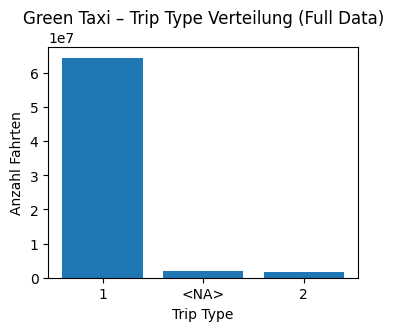

In [19]:
# trip_type – Verteilung Plot
plt.figure(figsize=(4,3))
plt.bar(df_trip_type["trip_type"].astype(str), df_trip_type["cnt"])
plt.title("Green Taxi – Trip Type Verteilung (Full Data)")
plt.xlabel("Trip Type")
plt.ylabel("Anzahl Fahrten")
plt.show()

Der Trip Type ist klar dominiert von Typ 1 (Street-Hail-Trips), während Dispatch-Trips (Typ 2) sowie fehlende Werte nur einen kleinen Anteil ausmachen. Der Green-Taxi-Datensatz bildet damit überwiegend spontane Straßenfahrten ab.

In [20]:
# store_and_fwd_flag – Verteilung
query_store = f"""
SELECT
  store_and_fwd_flag,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY store_and_fwd_flag
ORDER BY cnt DESC
"""
df_store = client.query(query_store).to_dataframe()
df_store

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,store_and_fwd_flag,cnt
0,N,65887576
1,None,1913192
2,Y,244829


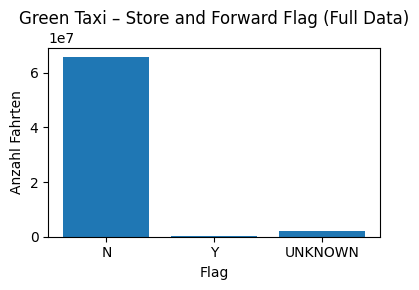

In [21]:
# store_and_fwd_flag – Verteilung Plot (Full Data)

# 1) Safety: falls df_store aus SQL kommt, kann store_and_fwd_flag None enthalten
df_store = df_store.copy()

# 2) Missing/None - "UNKNOWN" und alles zu String
df_store["store_and_fwd_flag"] = (
    df_store["store_and_fwd_flag"]
    .fillna("UNKNOWN")
    .astype(str)
)

# sinnvolle Reihenfolge
order = ["N", "Y", "UNKNOWN"]
df_store["store_and_fwd_flag"] = pd.Categorical(df_store["store_and_fwd_flag"], categories=order, ordered=True)
df_store = df_store.sort_values("store_and_fwd_flag")

# 3) Plot
plt.figure(figsize=(4, 3))
plt.bar(df_store["store_and_fwd_flag"], df_store["cnt"])
plt.title("Green Taxi – Store and Forward Flag (Full Data)")
plt.xlabel("Flag")
plt.ylabel("Anzahl Fahrten")
plt.tight_layout()
plt.show()

Die Verteilung des store_and_fwd_flag zeigt, dass der überwiegende Großteil der Fahrten mit N gekennzeichnet ist, d. h. die Daten wurden direkt und ohne Zwischenspeicherung an das System übertragen. Der Anteil von Y (Store-and-Forward aktiv) sowie UNKNOWN ist sehr gering, was darauf hindeutet, dass Verbindungsprobleme oder Offline-Übertragungen nur eine untergeordnete Rolle im Datensatz spielen.

# Zähl- & Strukturspalten

In [22]:
# passenger_count – Verteilung
query_passenger = f"""
SELECT
  passenger_count,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY passenger_count
ORDER BY passenger_count
"""
df_passenger = client.query(query_passenger).to_dataframe()
df_passenger

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,passenger_count,cnt
0,<NA>,1913192
1,0,63033
2,1,55895086
3,2,5094082
4,3,1295425
5,4,406863
6,5,2296023
7,6,1078037
8,7,1534
9,8,1762


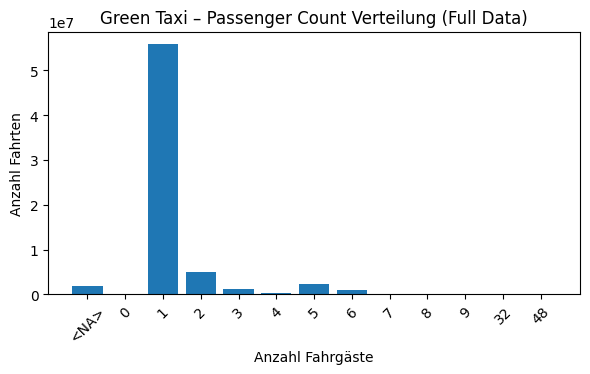

In [23]:
# passenger_count – Verteilung Plot
plt.figure(figsize=(6,4))
plt.bar(df_passenger["passenger_count"].astype(str), df_passenger["cnt"])
plt.title("Green Taxi – Passenger Count Verteilung (Full Data)")
plt.xlabel("Anzahl Fahrgäste")
plt.ylabel("Anzahl Fahrten")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Die Verteilung der passenger_count zeigt eine starke Dominanz von Fahrten mit einem einzelnen Fahrgast, die den überwiegenden Anteil des Datensatzes ausmachen. Mit steigender Fahrgastzahl nimmt die Häufigkeit stark ab. Werte größer als 6 treten nur vereinzelt auf und stellen potenzielle Ausreißer oder Sonderfälle dar.
Zusätzlich ist ein relevanter Anteil fehlender Werte (NULL) vorhanden, der bei späteren Analysen explizit berücksichtigt oder bereinigt werden sollte.

In [24]:
# duplicate_flag – Verteilung
query_duplicate = f"""
SELECT
  duplicate_flag,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY duplicate_flag
ORDER BY cnt DESC
"""
df_duplicate = client.query(query_duplicate).to_dataframe()
df_duplicate

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,duplicate_flag,cnt
0,N,68045023
1,Y,574


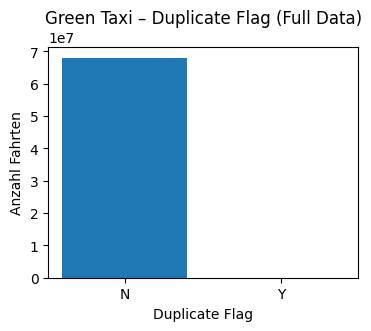

In [25]:
# duplicate_flag – Verteilung Plot
plt.figure(figsize=(4,3))
plt.bar(df_duplicate["duplicate_flag"].astype(str), df_duplicate["cnt"])
plt.title("Green Taxi – Duplicate Flag (Full Data)")
plt.xlabel("Duplicate Flag")
plt.ylabel("Anzahl Fahrten")
plt.show()

Die Analyse des duplicate_flag zeigt, dass der Datensatz nahezu keine als Duplikate gekennzeichneten Einträge enthält. Duplikate stellen mit einem Anteil von deutlich unter 0,01 % keinen relevanten Qualitätsfaktor dar und müssen in der weiteren Analyse nicht gesondert berücksichtigt werden.

In [26]:
# missing_flag – Verteilung
query_missing_flag = f"""
SELECT
  missing_flag,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY missing_flag
ORDER BY cnt DESC
"""
df_missing_flag = client.query(query_missing_flag).to_dataframe()
df_missing_flag

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,missing_flag,cnt
0,N,68045597


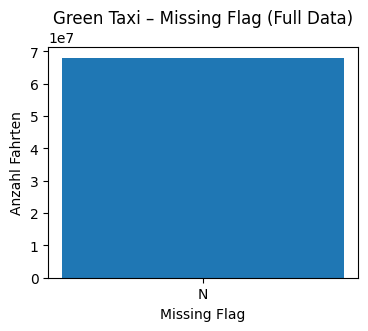

In [27]:
# missing_flag – Verteilung Plot
plt.figure(figsize=(4,3))
plt.bar(df_missing_flag["missing_flag"].astype(str), df_missing_flag["cnt"])
plt.title("Green Taxi – Missing Flag (Full Data)")
plt.xlabel("Missing Flag")
plt.ylabel("Anzahl Fahrten")
plt.show()

Die Analyse des missing_flag zeigt, dass keine Fahrten im Datensatz als „missing“ gekennzeichnet sind. Der missing_flag liefert damit keine zusätzliche analytische Information für die weitere Analyse.

# Monetäre Spalten

**fare_amount**

Der Grundpreis (fare_amount) wird in den späteren Abschnitten
ausführlich analysiert (Verteilung, Ausreißer, p99- und IQR-Zoom sowie
Zusammenhang mit Distanz und Fahrtdauer).
In diesem Abschnitt wird fare_amount daher erst einmal ausgelassen.


In [28]:
# Plausibilitätsprüfung: total_amount vs. Summe der Komponenten
query_total_check = f"""
SELECT
  COUNT(*) AS total_rows,
  COUNTIF(
    ABS(
      total_amount - (
        fare_amount
        + COALESCE(extra, 0)
        + COALESCE(mta_tax, 0)
        + COALESCE(improvement_surcharge, 0)
        + COALESCE(congestion_surcharge, 0)
        + COALESCE(tolls_amount, 0)
        + COALESCE(tip_amount, 0)
      )
    ) > 0.01
  ) AS inconsistent_rows
FROM {GREEN_TABLE}
"""
df_total_check = client.query(query_total_check).to_dataframe()

df_total_check["share_inconsistent"] = (
    df_total_check["inconsistent_rows"] / df_total_check["total_rows"]
)

df_total_check

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,total_rows,inconsistent_rows,share_inconsistent
0,68045597,1154212,0.016962


Die Plausibilitätsprüfung von total_amount gegenüber der Summe der Einzelkomponenten zeigt, dass der überwiegende Teil der Fahrten konsistent ist, jedoch bei etwa 1,7 % der Fahrten Abweichungen oberhalb der gewählten Toleranz auftreten. Diese Inkonsistenzen können durch Rundungseffekte, nachträgliche Anpassungen, systembedingte Zuschläge oder unvollständig berücksichtigte Gebühren entstehen. Insgesamt ist die monetäre Struktur des Datensatzes weitgehend plausibel, kleinere Abweichungen sollten jedoch bei detaillierten Preisanalysen berücksichtigt werden.

In [29]:
# Tip Amount – Anteil 0 vs >0 (Full Data)
query_tip_zero = f"""
SELECT
  CASE
    WHEN tip_amount = 0 THEN '0'
    WHEN tip_amount > 0 THEN '>0'
    ELSE 'negative'
  END AS tip_group,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY tip_group
ORDER BY cnt DESC
"""
df_tip_zero = client.query(query_tip_zero).to_dataframe()
df_tip_zero

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,tip_group,cnt
0,0,40506613
1,>0,27536824
2,negative,2160


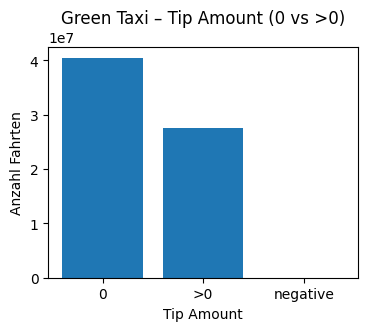

In [30]:
# Tip Amount – Anteil 0 vs >0 Plot
plt.figure(figsize=(4,3))
plt.bar(df_tip_zero["tip_group"], df_tip_zero["cnt"])
plt.title("Green Taxi – Tip Amount (0 vs >0)")
plt.xlabel("Tip Amount")
plt.ylabel("Anzahl Fahrten")
plt.show()

Ein Großteil der Fahrten weist kein Trinkgeld (tip_amount = 0) auf, während ein signifikanter Anteil positives Trinkgeld (>0) enthält. Negative Trinkgeldbeträge treten nur in sehr wenigen Fällen auf und deuten vermutlich auf Korrekturen oder Sonderfälle im Abrechnungssystem hin.

In [31]:
# Surcharge Columns
surcharge_cols = [
    "extra",
    "mta_tax",
    "improvement_surcharge",
    "congestion_surcharge",
    "tolls_amount"
]

In [32]:
for col in surcharge_cols:
    print(f"\n--- {col} ---")
    query = f"""
    SELECT
      {col} AS value,
      COUNT(*) AS cnt
    FROM {GREEN_TABLE}
    GROUP BY {col}
    ORDER BY cnt DESC
    """
    display(client.query(query).to_dataframe())


--- extra ---


/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,value,cnt
0,0.00,32907460
1,0.50,21660452
2,1.00,11517573
3,2.75,1280947
4,2.50,349246
...,...,...
221,1.71,1
222,5.20,1
223,2.20,1
224,-1.35,1



--- mta_tax ---


/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,value,cnt
0,0.50,65040024
1,0.00,2645024
2,1.50,223141
3,-0.50,136327
4,1.00,727
5,3.00,133
6,3.55,60
7,4.25,41
8,1.30,21
9,0.40,15



--- improvement_surcharge ---


/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,value,cnt
0,0.30,63716745
1,0.00,2375546
2,1.00,1822496
3,-0.30,124837
4,-1.00,5591
5,0.35,20
6,0.26,17
7,0.33,16
8,0.37,13
9,0.46,13



--- congestion_surcharge ---


/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,value,cnt
0,NaN,58614197
1,0.00,7626894
2,2.75,1795524
3,2.50,8645
4,-2.75,248
5,0.75,80
6,-2.50,5
7,2.00,2
8,-0.75,1
9,0.30,1



--- tolls_amount ---


/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,value,cnt
0,0.00,66278027
1,5.54,574790
2,5.76,469092
3,6.12,278316
4,6.55,103720
...,...,...
2179,1.38,1
2180,20.21,1
2181,2.95,1
2182,505.94,1


Die Analyse der verschiedenen Zuschlags-Spalten zeigt, dass der Gesamtfahrpreis im Green-Taxi-Datensatz aus mehreren klar standardisierten Zusatzkomponenten besteht, die jeweils unterschiedliche reale Kostenfaktoren abbilden. Der überwiegende Teil der Fahrten weist entweder feste Standardbeträge oder den Wert 0 auf, was auf klar definierte Regeln für die Erhebung dieser Zuschläge hindeutet.

Die Spalten extra, mta_tax und improvement_surcharge repräsentieren überwiegend pauschale Gebühren. extra steht typischerweise für zeitabhängige Zuschläge, etwa für Nachtfahrten oder Stoßzeiten. mta_tax ist eine festgelegte Abgabe an die Metropolitan Transportation Authority und tritt fast ausschließlich in standardisierter Höhe auf. Die improvement_surcharge stellt einen verpflichtenden Infrastruktur-Zuschlag dar, der zur Finanzierung des städtischen Verkehrssystems dient und ebenfalls überwiegend einen konstanten Betrag aufweist. Vereinzelte negative oder abweichende Werte in diesen Spalten sind selten und deuten eher auf Korrekturen oder Datenanomalien als auf reguläre Fahrten hin.

Die congestion_surcharge zeigt eine größere Anzahl fehlender Werte, was darauf schließen lässt, dass dieser Zuschlag nur für bestimmte Fahrten anfällt,etwa in verkehrsbelasteten Zonen oder zu bestimmten Zeitpunkten. Wo er erhoben wird, erscheint er meist als fester Betrag, was auf eine klar definierte Regelung zur Verkehrslenkung im Stadtzentrum hindeutet.

Die Spalte tolls_amount unterscheidet sich von den anderen Zuschlägen, da sie reale, streckenabhängige Kosten abbildet. Der Großteil der Fahrten enthält keinen Mautbetrag, während positive Werte nur bei Fahrten über mautpflichtige Brücken oder Tunnel auftreten. Sehr hohe Einzelwerte kommen selten vor und können auf außergewöhnliche Routen oder potenzielle Ausreißer hinweisen.

Insgesamt verdeutlichen die Surcharge-Analysen, dass die Zuschläge im Datensatz größtenteils regelbasiert, standardisiert und gut erklärbar sind. Abweichungen treten nur in einem sehr kleinen Anteil der Daten auf und liefern wichtige Hinweise auf Sonderfälle oder potenzielle Datenqualitätsprobleme, ohne die Gesamtstruktur der Preiskomposition wesentlich zu beeinträchtigen.

# Zeitliche Muster

In [33]:
# Fahrten nach Wochentag
query_weekday = f"""
SELECT
  EXTRACT(DAYOFWEEK FROM lpep_pickup_datetime) AS weekday,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY weekday
ORDER BY weekday
"""
df_weekday = client.query(query_weekday).to_dataframe()
df_weekday

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,weekday,cnt
0,1,9647376
1,2,8346429
2,3,8675339
3,4,9168013
4,5,9797181
5,6,10891845
6,7,11519414


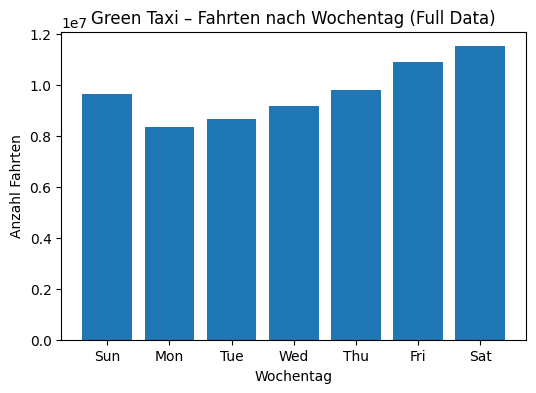

In [34]:
# Fahrten nach Wochentag Plot
weekday_labels = {
    1: "Sun", 2: "Mon", 3: "Tue", 4: "Wed",
    5: "Thu", 6: "Fri", 7: "Sat"
}

plt.figure(figsize=(6,4))
plt.bar(
    df_weekday["weekday"].map(weekday_labels),
    df_weekday["cnt"]
)
plt.title("Green Taxi – Fahrten nach Wochentag (Full Data)")
plt.xlabel("Wochentag")
plt.ylabel("Anzahl Fahrten")
plt.show()

Die Auswertung der Green-Taxi-Fahrten nach Wochentagen zeigt ein klar ausgeprägtes Wochenmuster. Die Anzahl der Fahrten ist zu Beginn der Woche am niedrigsten und steigt im Verlauf kontinuierlich an. Montag weist das geringste Fahrtenaufkommen auf, während die Werte von Dienstag bis Donnerstag moderat zunehmen. Freitag und insbesondere Samstag stellen die verkehrsreichsten Tage dar, mit dem höchsten Fahrtenvolumen am Samstag. Der Sonntag liegt leicht unter dem Freitag, aber deutlich über den frühen Wochentagen.

Dieses Muster lässt sich gut durch reale Nutzungsgewohnheiten erklären:
Unter der Woche werden Green Taxis primär für Alltags- und Arbeitswege genutzt, was ein relativ stabiles, aber begrenztes Fahrtenniveau erzeugt. Zum Wochenende hin verschiebt sich die Nutzung stärker in Richtung Freizeit-, Abend- und Nachtaktivitäten (z. B. Restaurant-, Bar- oder Eventbesuche), was insbesondere am Freitag und Samstag zu einem deutlich höheren Fahrtenaufkommen führt. Der etwas geringere Wert am Sonntag deutet darauf hin, dass zwar weiterhin Mobilitätsbedarf besteht, dieser jedoch im Vergleich zum Samstag bereits wieder abnimmt.

Insgesamt bestätigt die Analyse, dass Green-Taxi-Fahrten nicht gleichmäßig über die Woche verteilt sind, sondern stark von sozialen und zeitlichen Routinen beeinflusst werden. Dieses Wissen ist insbesondere relevant für spätere Analysen zu Nachfrageprognosen, Kapazitätsplanung oder zeitabhängigen Preis- bzw. Zuschlagsmodellen.

In [35]:
# Wochenend vs. Werktag – Verteilung
query_weekend = f"""
SELECT
  CASE
    WHEN EXTRACT(DAYOFWEEK FROM lpep_pickup_datetime) IN (1,7)
      THEN 'Weekend'
    ELSE 'Weekday'
  END AS day_type,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY day_type
"""
df_weekend = client.query(query_weekend).to_dataframe()
df_weekend

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,day_type,cnt
0,Weekend,21166790
1,Weekday,46878807


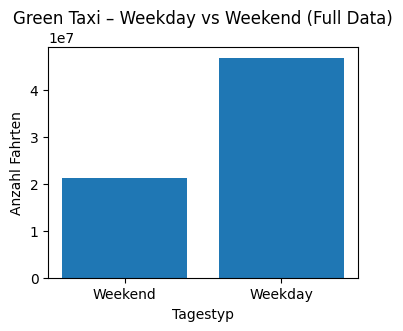

In [36]:
# Wochenend vs. Werktag – Verteilung Plot
plt.figure(figsize=(4,3))
plt.bar(df_weekend["day_type"], df_weekend["cnt"])
plt.title("Green Taxi – Weekday vs Weekend (Full Data)")
plt.xlabel("Tagestyp")
plt.ylabel("Anzahl Fahrten")
plt.show()

Insgesamt finden deutlich mehr Fahrten an Werktagen statt als am Wochenende. Dies ist jedoch vor allem auf die höhere Anzahl an Werktagen (fünf gegenüber zwei Tagen) zurückzuführen.

# Räumliche Spalten

In [37]:
# Top-10 Pickup-Zonen
query_pu_top = f"""
SELECT
  PULocationID,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY PULocationID
ORDER BY cnt DESC
LIMIT 10
"""
df_pu_top = client.query(query_pu_top).to_dataframe()
df_pu_top

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,PULocationID,cnt
0,74,4345463
1,75,3666938
2,41,3600256
3,7,3045674
4,82,2736650
5,166,2568296
6,255,2378338
7,42,2350082
8,181,2011578
9,97,1956548


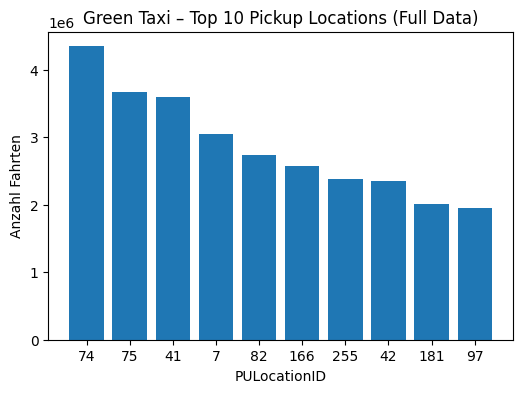

In [38]:
# Top-10 Pickup-Zonen Plot
plt.figure(figsize=(6,4))
plt.bar(df_pu_top["PULocationID"].astype(str), df_pu_top["cnt"])
plt.title("Green Taxi – Top 10 Pickup Locations (Full Data)")
plt.xlabel("PULocationID")
plt.ylabel("Anzahl Fahrten")
plt.show()

Die Auswertung der Top-10 Pickup-Zonen der Green Taxis zeigt eine starke räumliche Konzentration der Fahrten auf wenige geografische Bereiche. Besonders die Pickup-Zone mit der ID 74 weist mit rund 4,35 Millionen Fahrten die höchste Nachfrage auf, gefolgt von den Zonen 75 und 41. Insgesamt fällt auf, dass die Anzahl der Fahrten nach den ersten Rängen deutlich abnimmt, was auf klassische Nachfrage-Hotspots im Stadtgebiet hindeutet. Da die PULocationID jeweils eine offizielle Taxi-Zone in New York repräsentiert, spiegeln diese Ergebnisse reale Einstiegsorte mit hoher Bevölkerungsdichte, intensiver Nutzung oder besonderer infrastruktureller Bedeutung wider, etwa Wohn-, Geschäfts- oder Verkehrsknotenpunkte. Aus betriebswirtschaftlicher Sicht ist diese Konzentration relevant für die operative Steuerung des Taxiangebots, da sich Fahrer gezielt in nachfragestarken Zonen positionieren lassen, um Leerfahrten zu reduzieren und Wartezeiten zu verkürzen. Gleichzeitig liefert die Analyse eine wichtige Grundlage für Kapazitäts- und Schichtplanung sowie für weiterführende räumliche Analysen, beispielsweise durch die Zuordnung der Zonen zu konkreten Stadtteilen oder Boroughs.

In [39]:
# Top-10 Dropoff-Zonen
query_do_top = f"""
SELECT
  DOLocationID,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY DOLocationID
ORDER BY cnt DESC
LIMIT 10
"""
df_do_top = client.query(query_do_top).to_dataframe()
df_do_top

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,DOLocationID,cnt
0,74,2233379
1,42,2170634
2,41,1934990
3,7,1883172
4,129,1752752
5,181,1482870
6,75,1473832
7,166,1239647
8,82,1226949
9,61,1215582


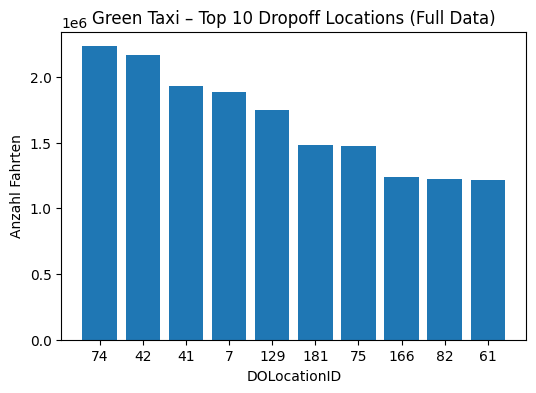

In [40]:
# Top-10 Dropoff-Zonen Plot
plt.figure(figsize=(6,4))
plt.bar(df_do_top["DOLocationID"].astype(str), df_do_top["cnt"])
plt.title("Green Taxi – Top 10 Dropoff Locations (Full Data)")
plt.xlabel("DOLocationID")
plt.ylabel("Anzahl Fahrten")
plt.show()

Die Analyse der Top-10 Dropoff-Zonen der Green Taxis zeigt, dass sich auch die Zielorte der Fahrten stark auf wenige geografische Zonen konzentrieren. Besonders die Dropoff-Zone mit der ID 74 weist mit rund 2,23 Millionen Fahrten die höchste Anzahl an Zielankünften auf, gefolgt von den Zonen 42 und 41. Ähnlich wie bei den Pickup-Zonen nimmt die Anzahl der Fahrten mit absteigendem Rang deutlich ab, was auf eine klare Bündelung der Fahrtenendpunkte in bestimmten Stadtbereichen hindeutet. Da die DOLocationID reale Taxi-Zonen in New York repräsentiert, spiegeln diese Ergebnisse typische Zielgebiete der Green Taxis wider, etwa Wohngebiete, Arbeitsstandorte oder zentrale Versorgungs- und Verkehrsknotenpunkte. Aus Business-Perspektive liefert diese Verteilung wichtige Erkenntnisse für die räumliche Nachfrageplanung, da sie zeigt, in welchen Gebieten Fahrten typischerweise enden und wo sich potenziell neue Anschlussfahrten ergeben, wodurch Standzeiten reduziert und die Effizienz der Fahrzeugnutzung gesteigert werden können.

In [41]:
# Anzahl Fahrten pro Pickup-Zone
query_pu_dist = f"""
SELECT
  PULocationID,
  COUNT(*) AS cnt
FROM {GREEN_TABLE}
GROUP BY PULocationID
"""
df_pu_dist = client.query(query_pu_dist).to_dataframe()

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


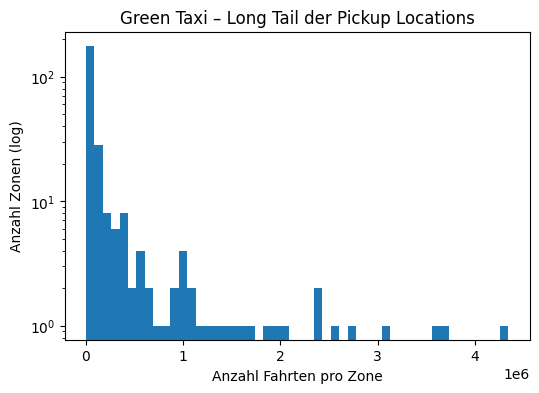

In [42]:
# Anzahl Fahrten pro Pickup-Zone Plot
plt.figure(figsize=(6,4))
plt.hist(df_pu_dist["cnt"], bins=50, log=True)
plt.title("Green Taxi – Long Tail der Pickup Locations")
plt.xlabel("Anzahl Fahrten pro Zone")
plt.ylabel("Anzahl Zonen (log)")
plt.show()

Die Verteilung der Fahrten pro Pickup-Zone weist eine stark rechtsschiefe Long-Tail-Struktur auf. Während wenige Zonen einen Großteil aller Fahrten bündeln, existiert eine Vielzahl von Zonen mit nur sehr wenigen Fahrten. Zur besseren Sichtbarkeit dieser Struktur wurde eine logarithmische Skalierung der y-Achse verwendet.

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


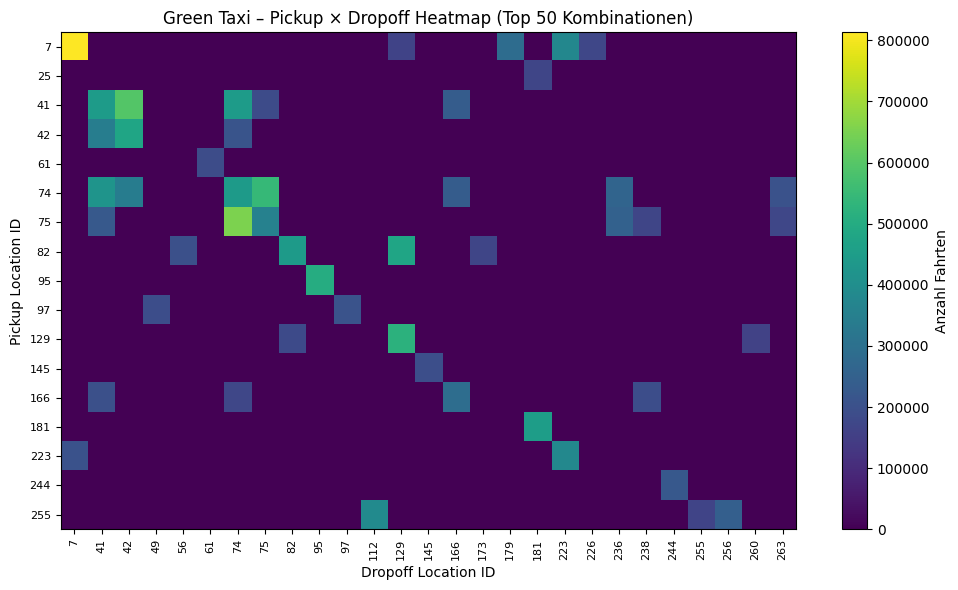

In [43]:
# Pickup × Dropoff Heatmap
# keine geografische Karte, sondern eine Beziehungsanalyse

query_od = f"""
SELECT
  PULocationID,
  DOLocationID,
  COUNT(1) AS cnt
FROM {GREEN_TABLE}
WHERE PULocationID IS NOT NULL
  AND DOLocationID IS NOT NULL
GROUP BY 1, 2
ORDER BY cnt DESC
LIMIT 50
"""

df_od = client.query(query_od).to_dataframe()

if df_od.empty:
    print("Keine Daten für Pickup/Dropoff Heatmap zurückbekommen (df_od ist leer).")
else:
    # Pivot (Matrix) bauen
    od_pivot = (
        df_od.pivot_table(
            index="PULocationID",
            columns="DOLocationID",
            values="cnt",
            aggfunc="sum",
            fill_value=0
        )
        .sort_index()
        .sort_index(axis=1)
    )

    od_matrix = od_pivot.to_numpy(dtype=float)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(od_matrix, aspect="auto")
    fig.colorbar(im, ax=ax, label="Anzahl Fahrten")

    ax.set_title("Green Taxi – Pickup × Dropoff Heatmap (Top 50 Kombinationen)")
    ax.set_xlabel("Dropoff Location ID")
    ax.set_ylabel("Pickup Location ID")

    # Achsenlabels (bei vielen IDs wird's eng – ist aber korrekt)
    ax.set_xticks(range(len(od_pivot.columns)))
    ax.set_xticklabels(od_pivot.columns.astype(int), rotation=90, fontsize=8)

    ax.set_yticks(range(len(od_pivot.index)))
    ax.set_yticklabels(od_pivot.index.astype(int), fontsize=8)

    plt.tight_layout()
    plt.show()

Die Pickup-×-Dropoff-Heatmap zeigt, dass sich die Green-Taxi-Fahrten nicht gleichmäßig zwischen allen Zonen verteilen, sondern dass bestimmte Kombinationen aus Abhol- und Zielzonen besonders häufig auftreten. Einzelne Felder mit deutlich höherer Intensität verdeutlichen, dass es dominante Relationen zwischen spezifischen Pickup- und Dropoff-Zonen gibt, während der Großteil möglicher Kombinationen nur selten oder gar nicht genutzt wird. Da jede Achse eine offizielle Taxi-Zone repräsentiert, beschreibt die Heatmap reale Verkehrsbeziehungen zwischen bestimmten Stadtgebieten und nicht lediglich einzelne Hotspots. Aus inhaltlicher Sicht deutet dies auf wiederkehrende Mobilitätsmuster hin, etwa regelmäßige Fahrten zwischen Wohn- und Arbeitsgebieten oder zwischen zentralen Versorgungs- und Transitstandorten. Für die betriebswirtschaftliche Betrachtung ist diese Beziehungsanalyse besonders relevant, da sie zeigt, wo sich Fahrten typischerweise bündeln und welche Relationen ein hohes Potenzial für Folgeaufträge oder optimierte Fahrerpositionierung bieten, wodurch Standzeiten reduziert und die Gesamteffizienz des Taxi-Einsatzes verbessert werden kann.

In [44]:
# Plot Sample (für Visualisierungen)
# - bewusst KEINE Filter auf Missing Values
# - Stichprobe dient ausschließlich der Exploration & Darstellung
# - Alle Kennzahlen / Quoten werden separat auf Full Data berechnet


PLOT_SAMPLE_SIZE = 50_000

query_green_plot = f"""
SELECT
    trip_distance,
    fare_amount,
    {PICKUP_COL}  AS pickup_datetime,
    {DROPOFF_COL} AS dropoff_datetime
FROM {GREEN_TABLE}
ORDER BY RAND()
LIMIT {PLOT_SAMPLE_SIZE}
"""

df_green_plot = client.query(query_green_plot).to_dataframe()

df_green_plot.head()

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,trip_distance,fare_amount,pickup_datetime,dropoff_datetime
0,2.40,10.50,2015-07-22 00:22:28,2015-07-22 00:34:07
1,0.99,7.00,2016-12-06 09:04:27,2016-12-06 09:12:30
2,2.23,10.00,2016-05-16 18:06:13,2016-05-16 18:19:22
3,4.97,20.00,2016-06-12 18:08:09,2016-06-12 18:30:28
4,2.54,16.73,2021-10-09 18:29:00,2021-10-09 18:45:00


Für die Visualisierungen wird eine zufällige Stichprobe von 50.000 Green-Taxi-Fahrten verwendet, um explorative Analysen performant und übersichtlich darzustellen. Die Stichprobe dient ausschließlich der Visualisierung und enthält bewusst keine Filterung nach Missing Values, sodass auch potenzielle Datenqualitätsprobleme sichtbar bleiben. Alle zentralen Kennzahlen und aggregierten Auswertungen werden weiterhin auf Basis des vollständigen Datensatzes berechnet, wodurch die Aussagekraft der Analyse erhalten bleibt.

In [45]:
# Analyse-Subset & abgeleitete Kennzahlen
# - Ableitungen dienen nur der Visualisierung
# - ursprüngliche Rohdaten bleiben unverändert

# Kopie des Plot-Samples
df_green = df_green_plot.copy()

df_green["duration_min"] = (
    df_green["dropoff_datetime"] - df_green["pickup_datetime"]
).dt.total_seconds() / 60

df_green.head()

,trip_distance,fare_amount,pickup_datetime,dropoff_datetime,duration_min
0,2.40,10.50,2015-07-22 00:22:28,2015-07-22 00:34:07,11.650000
1,0.99,7.00,2016-12-06 09:04:27,2016-12-06 09:12:30,8.050000
2,2.23,10.00,2016-05-16 18:06:13,2016-05-16 18:19:22,13.150000
3,4.97,20.00,2016-06-12 18:08:09,2016-06-12 18:30:28,22.316667
4,2.54,16.73,2021-10-09 18:29:00,2021-10-09 18:45:00,16.000000


Für die Analyse wird eine Kopie des zuvor gezogenen Plot-Samples verwendet, um daraus zusätzliche Kennzahlen für die Visualisierung abzuleiten, ohne die ursprünglichen Rohdaten zu verändern. Die Fahrtdauer wird aus der Differenz von Dropoff- und Pickup-Zeitstempel berechnet und kann dabei auch negative oder extreme Werte enthalten, die auf Datenqualitätsprobleme hinweisen. Die abgeleiteten Werte dienen ausschließlich der explorativen Analyse und werden nicht zur Berechnung zentraler Kennzahlen herangezogen.

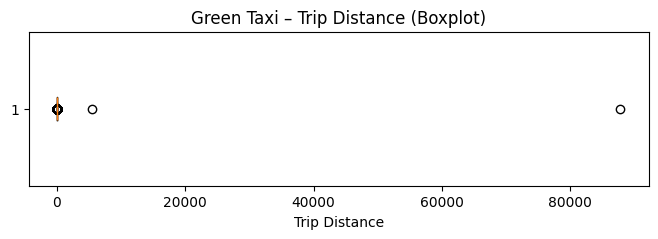

In [46]:
# Visualisierung der Verteilung und Ausreißer (Boxplot von Trip Distance)
plt.figure(figsize=(8, 2))
plt.boxplot(df_green["trip_distance"], vert=False)
plt.title("Green Taxi – Trip Distance (Boxplot)")
plt.xlabel("Trip Distance")
plt.show()

Der Boxplot der Fahrtdistanz im Green-Taxi-Sample zeigt eine extrem stark rechtsschiefe Verteilung mit einer Vielzahl ausgeprägter Ausreißer. Der zentrale Wertebereich liegt sehr nahe bei null, was darauf hindeutet, dass der Großteil der Fahrten kurze Distanzen umfasst. Dieser Kernbereich ist im Plot stark komprimiert dargestellt, da er im Vergleich zu den Extremwerten nur einen sehr kleinen Wertebereich einnimmt.

Gleichzeitig werden zahlreiche extreme Fahrtdistanzen sichtbar, die um mehrere Größenordnungen über dem typischen Bereich liegen und bis in sehr hohe Werte reichen. Solche Distanzen sind im Kontext innerstädtischer Green-Taxi-Fahrten als untypisch einzustufen und deuten auf fehlerhafte Messungen, inkonsistente GPS-Daten oder andere Datenqualitätsprobleme hin.

Die Visualisierung verdeutlicht, dass klassische Lagekennzahlen wie Mittelwert oder Standardabweichung durch diese Ausreißer stark verzerrt werden. Für BI-Analysen ist es daher notwendig, Verteilungen und Extremwerte explizit zu betrachten und geeignete Darstellungsformen zu wählen, um Fehlinterpretationen zu vermeiden. Der Boxplot macht diese Problematik deutlich sichtbar und liefert damit eine zentrale Grundlage für weiterführende Analysen in nachgelagerten Tasks.

# Quantile & IQR-Grenzen 
## für Zoom & Outlier-Definition der nächsten Diagramme (auf Basis der gesamten Daten)

In [47]:
# 1) FULL DATA Quantile berechnen
quant_sql = f"""
SELECT
  COUNT(1) AS total_rows,

  -- Trip Distance Quantile
  APPROX_QUANTILES(trip_distance, 100)[OFFSET(25)] AS td_q1,
  APPROX_QUANTILES(trip_distance, 100)[OFFSET(50)] AS td_median,
  APPROX_QUANTILES(trip_distance, 100)[OFFSET(75)] AS td_q3,
  APPROX_QUANTILES(trip_distance, 100)[OFFSET(95)] AS td_p95,
  APPROX_QUANTILES(trip_distance, 100)[OFFSET(99)] AS td_p99,

  -- Fare Amount Quantile
  APPROX_QUANTILES(fare_amount, 100)[OFFSET(25)] AS fare_q1,
  APPROX_QUANTILES(fare_amount, 100)[OFFSET(50)] AS fare_median,
  APPROX_QUANTILES(fare_amount, 100)[OFFSET(75)] AS fare_q3,
  APPROX_QUANTILES(fare_amount, 100)[OFFSET(95)] AS fare_p95,
  APPROX_QUANTILES(fare_amount, 100)[OFFSET(99)] AS fare_p99,

  -- Duration Quantile (Minuten) – Green: DATETIME_DIFF
  APPROX_QUANTILES(DATETIME_DIFF({DROPOFF_COL}, {PICKUP_COL}, SECOND)/60.0, 100)[OFFSET(25)] AS dur_q1,
  APPROX_QUANTILES(DATETIME_DIFF({DROPOFF_COL}, {PICKUP_COL}, SECOND)/60.0, 100)[OFFSET(50)] AS dur_median,
  APPROX_QUANTILES(DATETIME_DIFF({DROPOFF_COL}, {PICKUP_COL}, SECOND)/60.0, 100)[OFFSET(75)] AS dur_q3,
  APPROX_QUANTILES(DATETIME_DIFF({DROPOFF_COL}, {PICKUP_COL}, SECOND)/60.0, 100)[OFFSET(95)] AS dur_p95,
  APPROX_QUANTILES(DATETIME_DIFF({DROPOFF_COL}, {PICKUP_COL}, SECOND)/60.0, 100)[OFFSET(99)] AS dur_p99
FROM {GREEN_TABLE}
"""
df_q = client.query(quant_sql).to_dataframe()

# 2) Grenzen berechnen (IQR upper + p99)
td_q1, td_q3, td_p99 = map(float, [df_q.loc[0,"td_q1"], df_q.loc[0,"td_q3"], df_q.loc[0,"td_p99"]])
fare_q1, fare_q3, fare_p99 = map(float, [df_q.loc[0,"fare_q1"], df_q.loc[0,"fare_q3"], df_q.loc[0,"fare_p99"]])
dur_q1, dur_q3, dur_p99 = map(float, [df_q.loc[0,"dur_q1"], df_q.loc[0,"dur_q3"], df_q.loc[0,"dur_p99"]])

td_iqr_upper   = td_q3   + 1.5 * (td_q3   - td_q1)
fare_iqr_upper = fare_q3 + 1.5 * (fare_q3 - fare_q1)
dur_iqr_upper  = dur_q3  + 1.5 * (dur_q3  - dur_q1)

print("FULL DATA Grenzen (IQR upper & p99):")
print(f"trip_distance:  p99={td_p99:.2f} | IQR_upper={td_iqr_upper:.2f}")
print(f"fare_amount:    p99={fare_p99:.2f} | IQR_upper={fare_iqr_upper:.2f}")
print(f"duration_min:   p99={dur_p99:.2f} | IQR_upper={dur_iqr_upper:.2f}")

# 3) FULL DATA Outlier-Anteile zählen
outlier_sql = f"""
SELECT
  COUNT(1) AS total_rows,

  COUNTIF(trip_distance > {td_p99}) AS cnt_td_gt_p99,
  COUNTIF(trip_distance > {td_iqr_upper}) AS cnt_td_gt_iqr,

  COUNTIF(fare_amount > {fare_p99}) AS cnt_fare_gt_p99,
  COUNTIF(fare_amount > {fare_iqr_upper}) AS cnt_fare_gt_iqr,

  COUNTIF(DATETIME_DIFF({DROPOFF_COL}, {PICKUP_COL}, SECOND)/60.0 > {dur_p99}) AS cnt_dur_gt_p99,
  COUNTIF(DATETIME_DIFF({DROPOFF_COL}, {PICKUP_COL}, SECOND)/60.0 > {dur_iqr_upper}) AS cnt_dur_gt_iqr
FROM {GREEN_TABLE}
"""
df_out = client.query(outlier_sql).to_dataframe()

total = int(df_out.loc[0, "total_rows"])
for c in [x for x in df_out.columns if x.startswith("cnt_")]:
    df_out.loc[0, c.replace("cnt_", "share_")] = df_out.loc[0, c] / total

show_cols = [
    "total_rows",
    "cnt_td_gt_p99", "share_td_gt_p99",
    "cnt_td_gt_iqr", "share_td_gt_iqr",
    "cnt_fare_gt_p99", "share_fare_gt_p99",
    "cnt_fare_gt_iqr", "share_fare_gt_iqr",
    "cnt_dur_gt_p99", "share_dur_gt_p99",
    "cnt_dur_gt_iqr", "share_dur_gt_iqr",
]
df_out_display = df_out[show_cols].copy()
for c in [c for c in df_out_display.columns if c.startswith("share_")]:
    df_out_display[c] = (df_out_display[c] * 100).round(2)

df_out_display


/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


FULL DATA Grenzen (IQR upper & p99):
trip_distance:  p99=16.55 | IQR_upper=7.60
fare_amount:    p99=53.97 | IQR_upper=30.25
duration_min:   p99=67.78 | IQR_upper=35.12


,total_rows,cnt_td_gt_p99,share_td_gt_p99,cnt_td_gt_iqr,share_td_gt_iqr,cnt_fare_gt_p99,share_fare_gt_p99,cnt_fare_gt_iqr,share_fare_gt_iqr,cnt_dur_gt_p99,share_dur_gt_p99,cnt_dur_gt_iqr,share_dur_gt_iqr
0,68045597,708592,1.04,5175408,7.61,686439,1.01,4311110,6.34,698972,1.03,3952140,5.81


Der Code berechnet auf Basis des vollständigen Datensatzes robuste Schwellenwerte zur Identifikation von Ausreißern für Trip-Distance, Fare-Amount und Fahrtdauer. Zunächst werden mithilfe von approximierten Quantilen die p99-Werte sowie die Quartile Q1 und Q3 bestimmt, aus denen anschließend die obere IQR-Grenze (Q3 + 1,5 × IQR) abgeleitet wird. Diese Grenzen werden anschließend in einer zweiten Abfrage verwendet, um zu zählen, wie viele Fahrten die jeweiligen p99- und IQR-Schwellen überschreiten, und um deren Anteile am Gesamtdatensatz zu berechnen. Die resultierenden Kennzahlen dienen nicht der Bereinigung der Daten, sondern ausschließlich der transparenten Definition und Quantifizierung von Ausreißern, die in den folgenden Visualisierungen gezielt hervorgehoben werden.

In [ ]:
# Gesamt-Outlier-Rate (Union) + Verteilung
# Definition: Outlier wenn eins davon (trip_distance, fare_amount, duration) > IQR_upper

outlier_union_sql = f"""
WITH base AS (
  SELECT
    trip_distance,
    fare_amount,
    DATETIME_DIFF({DROPOFF_COL}, {PICKUP_COL}, SECOND)/60.0 AS duration_min
  FROM {GREEN_TABLE}
),
flags AS (
  SELECT
    trip_distance > {td_iqr_upper}   AS o_td,
    fare_amount   > {fare_iqr_upper} AS o_fare,
    duration_min  > {dur_iqr_upper}  AS o_dur
  FROM base
)
SELECT
  COUNT(1) AS total_rows,

  -- Union: "irgendwas ist Outlier"
  COUNTIF(o_td OR o_fare OR o_dur) AS cnt_any_outlier,
  SAFE_DIVIDE(COUNTIF(o_td OR o_fare OR o_dur), COUNT(1)) AS share_any_outlier,

  -- Verteilung (welche Art von Outlier)
  COUNTIF(o_td AND NOT o_fare AND NOT o_dur) AS cnt_td_only,
  COUNTIF(NOT o_td AND o_fare AND NOT o_dur) AS cnt_fare_only,
  COUNTIF(NOT o_td AND NOT o_fare AND o_dur) AS cnt_dur_only,

  COUNTIF(o_td AND o_fare AND NOT o_dur) AS cnt_td_fare,
  COUNTIF(o_td AND NOT o_fare AND o_dur) AS cnt_td_dur,
  COUNTIF(NOT o_td AND o_fare AND o_dur) AS cnt_fare_dur,

  COUNTIF(o_td AND o_fare AND o_dur) AS cnt_all_three
FROM flags
"""

df_out_union = client.query(outlier_union_sql).to_dataframe()

# Shares ergänzen
total = int(df_out_union.loc[0, "total_rows"])
for c in [x for x in df_out_union.columns if x.startswith("cnt_")]:
    if c != "cnt_any_outlier":
        df_out_union.loc[0, c.replace("cnt_", "share_")] = df_out_union.loc[0, c] / total
df_out_union.loc[0, "share_any_outlier"] = df_out_union.loc[0, "share_any_outlier"]

# Anzeigeaufbereitung
share_cols = [c for c in df_out_union.columns if c.startswith("share_")]
df_out_union_disp = df_out_union.copy()
df_out_union_disp[share_cols] = (df_out_union_disp[share_cols] * 100).round(2)

df_out_union_disp

/Users/nicolapany/Documents/GitHub/bi_project_task2/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,total_rows,cnt_any_outlier,share_any_outlier,cnt_td_only,cnt_fare_only,cnt_dur_only,cnt_td_fare,cnt_td_dur,cnt_fare_dur,cnt_all_three,share_td_only,share_fare_only,share_dur_only,share_td_fare,share_td_dur,share_fare_dur,share_all_three
0,68045597,7184704,10.56,1498510,400204,1230598,1333850,144486,378494,2198562,2.2,0.59,1.81,1.96,0.21,0.56,3.23


Die Tabelle zeigt die Gesamtanzahl und die Verteilung der Ausreißer im Datensatz der Green Taxis. Grundlage der Analyse ist eine klare Ausreißerdefinition auf Basis der Interquartilsabstände (IQR): Eine Fahrt wird als Ausreißer klassifiziert, sobald mindestens eines der drei betrachteten Merkmale Fahrtdistanz, Fahrpreis oder Fahrtdauer oberhalb der jeweils berechneten IQR-Obergrenze liegt. Insgesamt umfasst der Datensatz rund 68,0 Millionen Fahrten, von denen etwa 7,18 Millionen als Ausreißer identifiziert werden. Dies entspricht einem Anteil von 10,56 Prozent, sodass ungefähr jede zehnte Fahrt mindestens eine auffällige Ausprägung aufweist. Für einen großvolumigen, realen Mobilitätsdatensatz ist dieser Anteil nicht ungewöhnlich und verdeutlicht, dass Extremwerte ein relevanter Bestandteil der Daten sind.

Ein wesentlicher Teil der Ausreißer tritt nicht isoliert, sondern in Kombination mehrerer Merkmale auf. Besonders auffällig ist der Anteil der Fahrten, die gleichzeitig in allen drei Dimensionen als Ausreißer gelten. Rund 3,23 Prozent aller Fahrten weisen gleichzeitig eine ungewöhnlich hohe Fahrtdistanz, einen außergewöhnlich hohen Fahrpreis und eine sehr lange Fahrtdauer auf. Diese Fahrten stellen die extremsten Fälle im Datensatz dar und können auf Sonderfahrten, ungewöhnliche Verkehrsbedingungen oder auch auf fehlerhafte oder unplausible Zeit- oder Abrechnungsdaten hindeuten. Darüber hinaus zeigt sich, dass weitere Ausreißer häufig in genau zwei Merkmalen gleichzeitig auftreten, etwa bei Kombinationen aus hoher Distanz und hohem Fahrpreis oder aus langer Fahrtdauer und hoher Distanz. Dies unterstreicht den engen sachlichen Zusammenhang zwischen den betrachteten Variablen, da lange Fahrten in der Regel sowohl mehr Zeit als auch höhere Kosten verursachen.

Reine Einzel-Ausreißer sind im Vergleich seltener. Etwa 2,20 Prozent aller Fahrten weisen ausschließlich eine auffällige Fahrtdistanz auf, während 1,81 Prozent nur durch eine ungewöhnlich lange Fahrtdauer auffallen. Isolierte Preis-Ausreißer treten mit einem Anteil von lediglich 0,59 Prozent am seltensten auf. Dieses Muster legt nahe, dass hohe Fahrpreise in den meisten Fällen durch entsprechend lange Strecken oder lange Fahrzeiten erklärbar sind und nur selten ohne einen solchen Zusammenhang auftreten.

Insgesamt zeigt die Analyse, dass Ausreißer im Green-Taxi-Datensatz keine zufälligen Einzelfälle darstellen, sondern häufig strukturiert und logisch erklärbar sind. Die transparente Quantifizierung des Anteils und der Verteilung dieser Ausreißer schafft eine belastbare Grundlage für weitere Analysen und macht deutlich, dass eine differenzierte Behandlung von Extremwerten sinnvoller ist als eine pauschale Entfernung aus dem Datensatz.

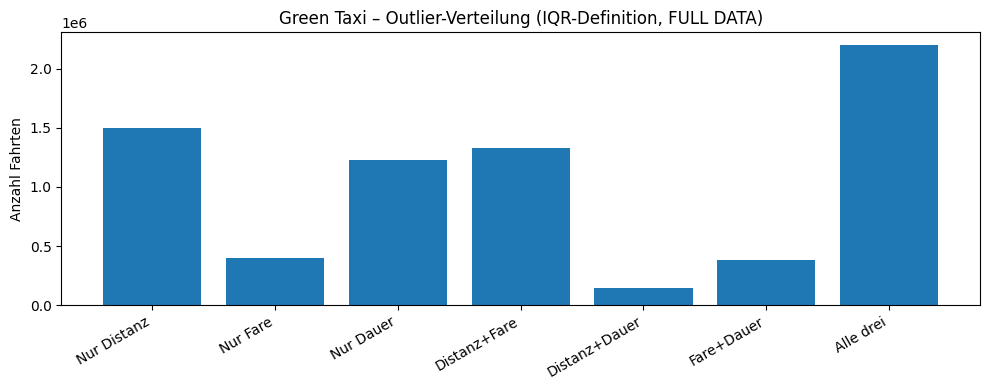

In [49]:
cats = [
    ("Nur Distanz", "cnt_td_only"),
    ("Nur Fare", "cnt_fare_only"),
    ("Nur Dauer", "cnt_dur_only"),
    ("Distanz+Fare", "cnt_td_fare"),
    ("Distanz+Dauer", "cnt_td_dur"),
    ("Fare+Dauer", "cnt_fare_dur"),
    ("Alle drei", "cnt_all_three"),
]

vals = [int(df_out_union.loc[0, k]) for _, k in cats]
labels = [n for n, _ in cats]

plt.figure(figsize=(10,4))
plt.bar(labels, vals)
plt.xticks(rotation=30, ha="right")
plt.title("Green Taxi – Outlier-Verteilung (IQR-Definition, FULL DATA)")
plt.ylabel("Anzahl Fahrten")
plt.tight_layout()
plt.show()

Die Grafik zeigt, dass Ausreißer im Green-Taxi-Datensatz überwiegend nicht isoliert, sondern als kombinierte Extremfälle auftreten. Besonders häufig sind Fahrten, die gleichzeitig in Fahrtdistanz, Fahrpreis und Fahrtdauer auffällig sind. Kombinationen aus zwei Merkmalen treten ebenfalls deutlich häufiger auf als reine Einzel-Ausreißer, insbesondere bei Distanz und Preis. Die Visualisierung verdeutlicht damit, dass Ausreißer meist strukturiert und sachlich erklärbar sind und nicht zufällig im Datensatz verteilt auftreten.

# Histogramme usw.

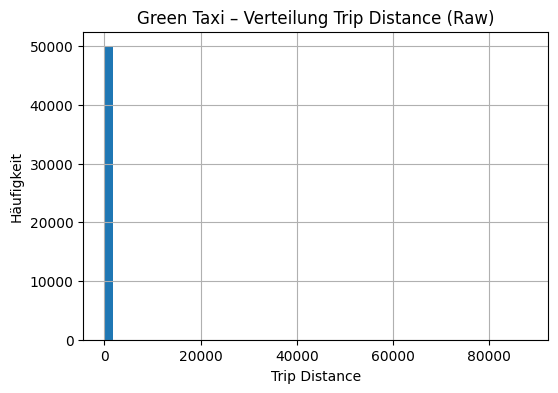

In [50]:
# Histogramme Trip Distance – Raw vs. Zoom View
# 1) Raw Histogramm (inkl. Ausreißer)
plt.figure(figsize=(6, 4))
df_green["trip_distance"].hist(bins=50)
plt.title("Green Taxi – Verteilung Trip Distance (Raw)")
plt.xlabel("Trip Distance")
plt.ylabel("Häufigkeit")
plt.show()

Das Histogramm der Fahrtdistanz auf Basis der ungefilterten Green-Taxi-Stichprobe zeigt eine extrem stark verzerrte Verteilung. Nahezu die gesamte Häufigkeit konzentriert sich auf einen sehr schmalen Bereich nahe null, während der restliche Wertebereich im Diagramm nahezu leer erscheint.

Dieses Erscheinungsbild ist nicht auf einen Darstellungsfehler zurückzuführen, sondern wird durch wenige extrem große Fahrtdistanzen verursacht, die die Skala der x-Achse dominieren. Dadurch wird der für die Mehrzahl der Fahrten relevante Distanzbereich visuell stark komprimiert und ist in dieser Darstellung kaum differenziert erkennbar.

Das Histogramm verdeutlicht damit anschaulich, dass eine direkte Analyse der Verteilung ohne zusätzliche Kontextualisierung oder alternative Darstellungsformen nur eingeschränkt interpretierbar ist. Insbesondere die starke Verzerrung durch Ausreißer stellt ein zentrales Datenqualitätsproblem dar, das bei BI-Analysen berücksichtigt werden muss.

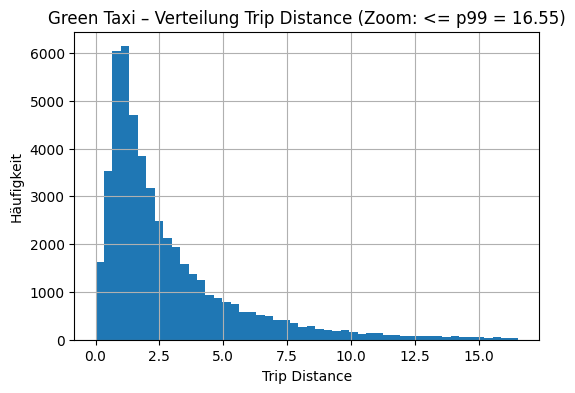

In [51]:
# 2) Zoom-Histogramm (zur besseren Lesbarkeit)
# Keine Bereinigung, sondern reine Visualisierungs-Zoom-Stufe
# Zoom-Grenze datengetrieben (p99 aus Full Data)
td_p99 = float(df_q.loc[0, "td_p99"])
df_green_trip_zoom = df_green[
    (df_green["trip_distance"] >= 0) &
    (df_green["trip_distance"] <= td_p99)
]

plt.figure(figsize=(6, 4))
df_green_trip_zoom["trip_distance"].hist(bins=50)
plt.title(f"Green Taxi – Verteilung Trip Distance (Zoom: <= p99 = {td_p99:.2f})")
plt.xlabel("Trip Distance")
plt.ylabel("Häufigkeit")
plt.show()

Das gezoomte Histogramm der Trip Distance zeigt die Verteilung der Fahrtdistanzen bis zur p99-Grenze und blendet extreme Ausreißer bewusst aus, um die typische Struktur der Daten sichtbar zu machen. Der Großteil der Fahrten konzentriert sich auf kurze Distanzen, während die Häufigkeit mit zunehmender Strecke stark abnimmt, was auf eine deutlich rechtsschiefe Verteilung hinweist. Durch den Zoom auf die p99-Schwelle wird die Hauptmasse der Fahrten klar erkennbar, ohne dass einzelne Extremwerte die Skalierung verzerren.

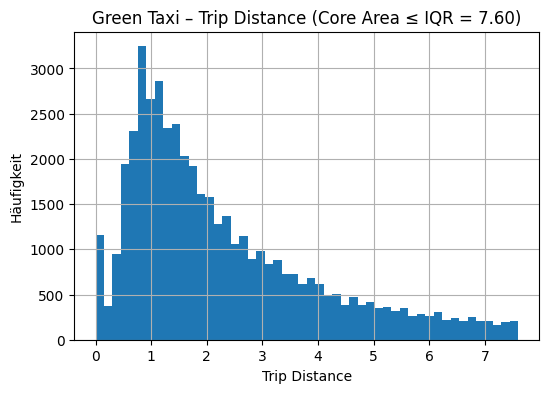

In [52]:
# Zusätzlicher Zoom: Kernbereich (IQR)
# dient der besseren Interpretation des typischen Bereichs

td_q1 = float(df_q.loc[0, "td_q1"])
td_q3 = float(df_q.loc[0, "td_q3"])
td_iqr_upper = td_q3 + 1.5 * (td_q3 - td_q1)

df_green_trip_zoom_iqr = df_green[
    (df_green["trip_distance"] >= 0) &
    (df_green["trip_distance"] <= td_iqr_upper)
]

plt.figure(figsize=(6, 4))
df_green_trip_zoom_iqr["trip_distance"].hist(bins=50)
plt.title(f"Green Taxi – Trip Distance (Core Area ≤ IQR = {td_iqr_upper:.2f})")
plt.xlabel("Trip Distance")
plt.ylabel("Häufigkeit")
plt.show()

Das Histogramm des Kernbereichs der Trip Distance, begrenzt durch die IQR-Obergrenze, fokussiert sich auf den typischen Wertebereich der Fahrtdistanzen und schließt extreme Ausreißer konsequent aus. Dadurch wird die zentrale Struktur der Verteilung besonders deutlich sichtbar: Die meisten Fahrten liegen im unteren Distanzbereich, während die Häufigkeit mit zunehmender Strecke kontinuierlich abnimmt. Die rechtsschiefe Verteilung bestätigt, dass kurze Fahrten den Normalfall im Green-Taxi-Verkehr darstellen, während längere Strecken zwar vorkommen, aber klar die Ausnahme bilden.

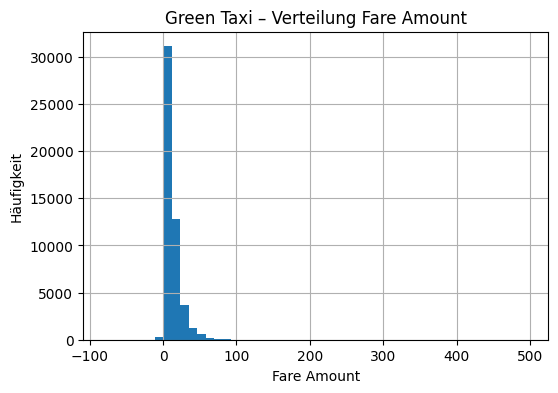

In [53]:
# Histogramm Fare Amount – Raw (inkl. Ausreißer)
# Ziel: Visualisierung der Preisverteilung ohne Bereinigung, 
# um potenzielle Datenqualitätsprobleme sichtbar zu machen
plt.figure(figsize=(6,4))
df_green["fare_amount"].hist(bins=50)
plt.title("Green Taxi – Verteilung Fare Amount")
plt.xlabel("Fare Amount")
plt.ylabel("Häufigkeit")
plt.show()

Das Histogramm der Fahrpreise auf Basis der ungefilterten Green-Taxi-Stichprobe zeigt eine deutlich rechtsschiefe Verteilung. Der überwiegende Teil der Fahrten weist niedrige bis mittlere Fahrpreise auf, während mit zunehmendem Fare Amount die Häufigkeit stark abnimmt. Der zentrale Wertebereich ist dabei im unteren Bereich der Skala konzentriert.

Gleichzeitig werden sowohl sehr hohe als auch negative Fahrpreiswerte sichtbar. Insbesondere die negativen Fare Amounts, die links im Histogramm erkennbar sind, stellen aus fachlicher Sicht unplausible Werte dar und deuten auf fehlerhafte Abrechnungen, Korrekturbuchungen oder unvollständig erfasste Transaktionen hin. Auch einzelne sehr hohe Fahrpreise tragen zur Verzerrung der Verteilung bei.

Die Darstellung verdeutlicht, dass aggregierte Kennzahlen wie der durchschnittliche Fahrpreis durch wenige extreme oder fehlerhafte Werte erheblich beeinflusst werden können. Für BI-Analysen ist es daher notwendig, die Preisverteilung sowohl in einer ungefilterten Rohdarstellung als auch in ergänzenden, fokussierten Darstellungen zu betrachten, um die zugrunde liegenden Strukturen korrekt interpretieren zu können.

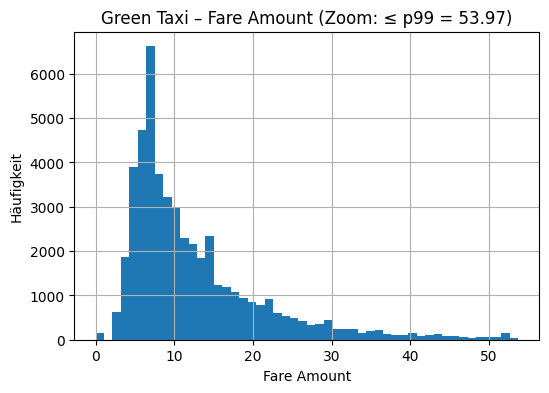

In [54]:
# Zoom-Histogramm Fare Amount (<= p99)
# Keine Bereinigung – Zoom-Grenze datengetrieben aus Full Data

fare_p99 = float(df_q.loc[0, "fare_p99"])

df_green_fare_zoom = df_green[
    (df_green["fare_amount"] >= 0) &
    (df_green["fare_amount"] <= fare_p99)
]

plt.figure(figsize=(6, 4))
df_green_fare_zoom["fare_amount"].hist(bins=50)
plt.title(f"Green Taxi – Fare Amount (Zoom: ≤ p99 = {fare_p99:.2f})")
plt.xlabel("Fare Amount")
plt.ylabel("Häufigkeit")
plt.show()

Das gezoomte Histogramm des Fare Amount zeigt die Verteilung der Fahrpreise bis zur p99-Grenze und blendet extreme Ausreißer gezielt aus. Der Großteil der Fahrten konzentriert sich auf niedrige bis mittlere Fahrpreise, während höhere Beträge mit zunehmender Höhe deutlich seltener auftreten. Die rechtsschiefe Verteilung verdeutlicht, dass typische Green-Taxi-Fahrten vergleichsweise günstig sind und hohe Fahrpreise klar die Ausnahme darstellen. Durch den Zoom auf die p99-Schwelle wird die Struktur der Hauptverteilung deutlich sichtbar, ohne dass einzelne Extremwerte die Darstellung dominieren.

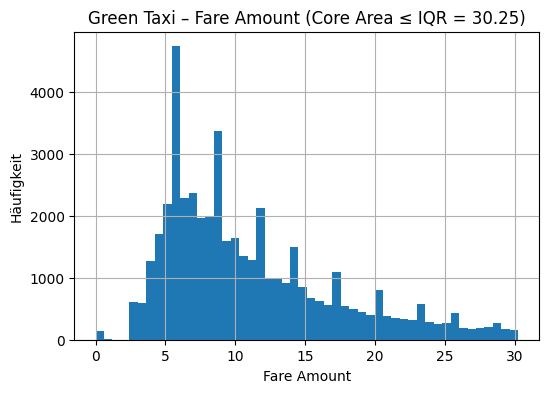

In [55]:
# Kernbereich der Fare Amounts (IQR)
# Fokus auf typischen Preisbereich

fare_q1 = float(df_q.loc[0, "fare_q1"])
fare_q3 = float(df_q.loc[0, "fare_q3"])
fare_iqr_upper = fare_q3 + 1.5 * (fare_q3 - fare_q1)

df_green_fare_iqr = df_green[
    (df_green["fare_amount"] >= 0) &
    (df_green["fare_amount"] <= fare_iqr_upper)
]

plt.figure(figsize=(6, 4))
df_green_fare_iqr["fare_amount"].hist(bins=50)
plt.title(f"Green Taxi – Fare Amount (Core Area ≤ IQR = {fare_iqr_upper:.2f})")
plt.xlabel("Fare Amount")
plt.ylabel("Häufigkeit")
plt.show()

Das Histogramm des Kernbereichs der Fare Amounts, begrenzt durch die IQR-Obergrenze, konzentriert sich auf den typischen Preisbereich der Green-Taxi-Fahrten und schließt extreme Ausreißer aus. Die Verteilung zeigt eine klare Häufung niedriger bis mittlerer Fahrpreise, während höhere Beträge zunehmend seltener auftreten. Die rechtsschiefe Struktur verdeutlicht, dass der überwiegende Teil der Fahrten in einem moderaten Preisrahmen liegt, während hohe Fahrpreise die Ausnahme darstellen.

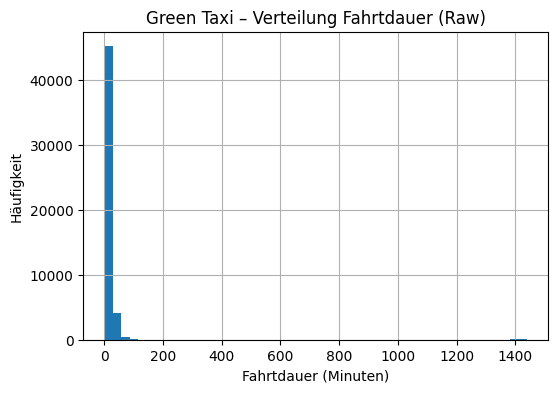

In [56]:
# RAW Histogramm Fahrtdauer (inkl. Ausreißer)

plt.figure(figsize=(6, 4))
df_green["duration_min"].hist(bins=50)
plt.title("Green Taxi – Verteilung Fahrtdauer (Raw)")
plt.xlabel("Fahrtdauer (Minuten)")
plt.ylabel("Häufigkeit")
plt.show()

Das Histogramm der Fahrtdauer auf Basis der ungefilterten Green-Taxi-Stichprobe zeigt eine stark verzerrte Verteilung. Der Großteil der Fahrten konzentriert sich auf sehr kurze Fahrtdauern im unteren Minutenbereich, während der restliche Wertebereich im Diagramm nahezu leer erscheint.

Dieses Bild entsteht nicht durch einen Darstellungsfehler, sondern durch wenige extrem lange Fahrten, die die Skalierung der x-Achse dominieren. Einzelne Datensätze weisen Fahrtdauern von mehreren hundert bis über eintausend Minuten auf, wodurch der für die Mehrzahl der Fahrten relevante Bereich visuell stark komprimiert wird.

Die Rohdarstellung verdeutlicht, dass ohne zusätzliche Kontextualisierung keine differenzierte Aussage über die typische Fahrtdauer möglich ist. Insbesondere extreme Werte beeinflussen die Visualisierung und erschweren die Interpretation der zugrunde liegenden Verteilung erheblich.

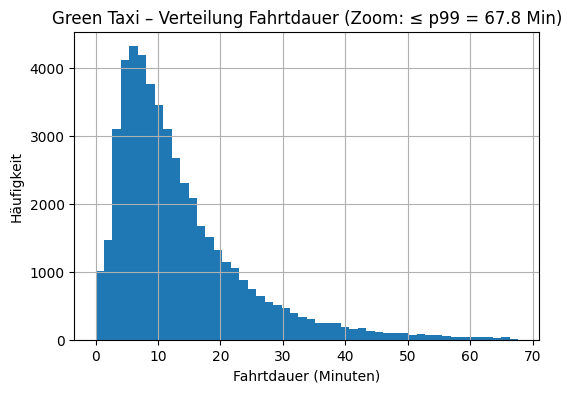

In [57]:
# Zoom Histogramm (p99, datengetrieben)
# negative Werte raus, damit die Achse sinnvoll bleibt

df_green_duration_zoom_p99 = df_green[
    (df_green["duration_min"] >= 0) &
    (df_green["duration_min"] <= dur_p99)
]

plt.figure(figsize=(6, 4))
df_green_duration_zoom_p99["duration_min"].hist(bins=50)
plt.title(f"Green Taxi – Verteilung Fahrtdauer (Zoom: ≤ p99 = {dur_p99:.1f} Min)")
plt.xlabel("Fahrtdauer (Minuten)")
plt.ylabel("Häufigkeit")
plt.show()

Das gezoomte Histogramm der Fahrtdauer zeigt die Verteilung der Fahrtzeiten bis zur p99-Grenze und blendet extrem lange Fahrten gezielt aus. Der Großteil der Fahrten liegt im unteren Minutenbereich, während mit zunehmender Dauer die Häufigkeit deutlich abnimmt, was auf eine klar rechtsschiefe Verteilung hinweist. Durch die Begrenzung auf die p99-Schwelle wird die typische Struktur der Fahrtdauern sichtbar, ohne dass einzelne Extremwerte die Darstellung verzerren.

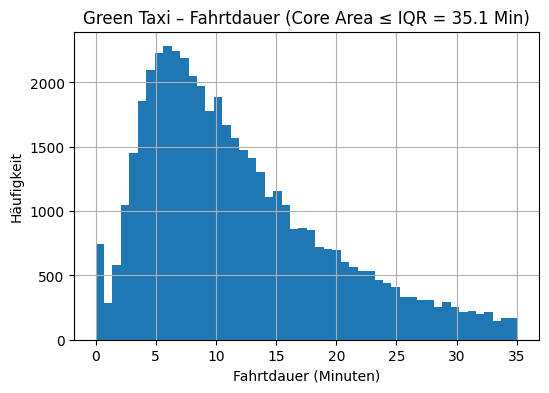

In [58]:
# Zoom nach IQR

df_green_duration_zoom_iqr = df_green[
    (df_green["duration_min"] >= 0) &
    (df_green["duration_min"] <= dur_iqr_upper)
]

plt.figure(figsize=(6, 4))
df_green_duration_zoom_iqr["duration_min"].hist(bins=50)
plt.title(f"Green Taxi – Fahrtdauer (Core Area ≤ IQR = {dur_iqr_upper:.1f} Min)")
plt.xlabel("Fahrtdauer (Minuten)")
plt.ylabel("Häufigkeit")
plt.show()

Das Histogramm des Kernbereichs der Fahrtdauer, begrenzt durch die IQR-Obergrenze, fokussiert sich auf den typischen Zeitrahmen der Green-Taxi-Fahrten und schließt extreme Langfahrten aus. Die Verteilung zeigt eine deutliche Häufung kürzerer Fahrten, während mit zunehmender Dauer die Häufigkeit kontinuierlich abnimmt. Die rechtsschiefe Struktur verdeutlicht, dass kurze bis mittlere Fahrtdauern den Regelfall darstellen, während längere Fahrten zwar vorkommen, aber klar die Ausnahme bilden.

# Scatterplots 
## zur Beleuchtung von Zusammenhängen

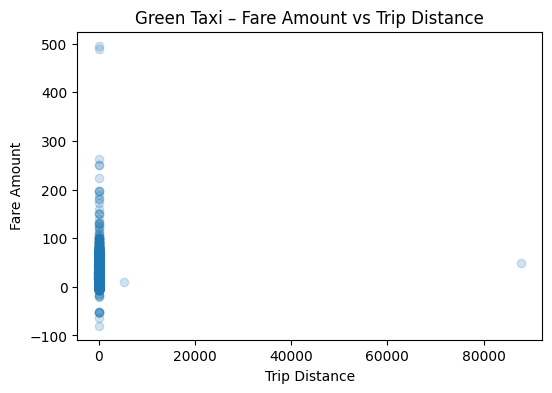

In [59]:
# Scatterplot – Zusammenhang zwischen Trip Distance und Fare Amount
# Ziel: Sichtbarmachung von Korrelationen und Ausreißern

plt.figure(figsize=(6,4))
plt.scatter(df_green["trip_distance"], df_green["fare_amount"], alpha=0.2)
plt.title("Green Taxi – Fare Amount vs Trip Distance")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.show()

Der Scatterplot zeigt den Zusammenhang zwischen Trip Distance und Fare Amount und macht hauptsächlich auffällige Ausreißer sichtbar. Um Zusammenhänge sichtbar zu machen und das Diagramm robuster gegen Ausreißer zu machen, wenden wir auch hier wieder unseren Zoom an.

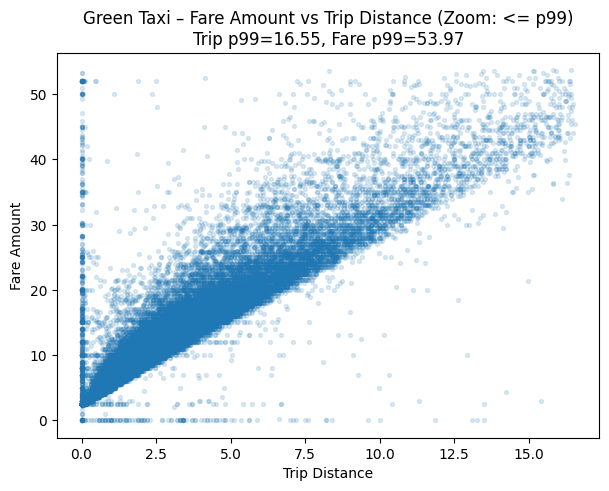

Zoom rows: 49191 of 50000


In [60]:
# Scatterplot Zoom– Zusammenhang zwischen Trip Distance und Fare Amount
# Um die Beziehung im "typischen" Kernbereich sichtbar zu machen

# p99-Grenzen aus der Quantil-Tabelle 
td_p99 = float(df_q.loc[0, "td_p99"])
fare_p99 = float(df_q.loc[0, "fare_p99"])

df_green_scatter_zoom = df_green[
    (df_green["trip_distance"] >= 0) &
    (df_green["fare_amount"] >= 0) &
    (df_green["trip_distance"] <= td_p99) &
    (df_green["fare_amount"] <= fare_p99)
]

plt.figure(figsize=(7, 5))
plt.scatter(
    df_green_scatter_zoom["trip_distance"],
    df_green_scatter_zoom["fare_amount"],
    alpha=0.15,
    s=8
)

plt.title(f"Green Taxi – Fare Amount vs Trip Distance (Zoom: <= p99)\n"
          f"Trip p99={td_p99:.2f}, Fare p99={fare_p99:.2f}")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.show()

print("Zoom rows:", len(df_green_scatter_zoom), "of", len(df_green))

Der gezoomte Scatterplot (bis zur p99-Grenze für Trip Distance und Fare Amount) macht den Zusammenhang zwischen Fahrtdistanz und Fahrpreis im typischen Wertebereich deutlich sichtbar. Es zeigt sich eine klare positive Beziehung: Mit zunehmender Fahrtdistanz steigt der Fahrpreis nahezu linear an, was dem erwarteten Tarifmodell (Grundpreis plus distanzabhängiger Anteil) entspricht. Die dichte Punktwolke im unteren Distanzbereich verdeutlicht, dass der Großteil der Green-Taxi-Fahrten kurze Strecken mit vergleichsweise niedrigen Preisen umfasst. Die leichte vertikale Streuung bei gleicher Distanz weist auf zusätzliche preisbestimmende Faktoren hin, wie Wartezeiten, Mindestbeträge, Zuschläge, Trinkgelder oder Verkehrsbedingungen. Durch die p99-Begrenzung werden extreme Ausreißer bewusst ausgeblendet, sodass die grundlegende Preis-Distanz-Logik des realen Taxi­betriebs klar erkennbar bleibt und nicht durch fehlerhafte oder außergewöhnliche Fahrten überlagert wird.

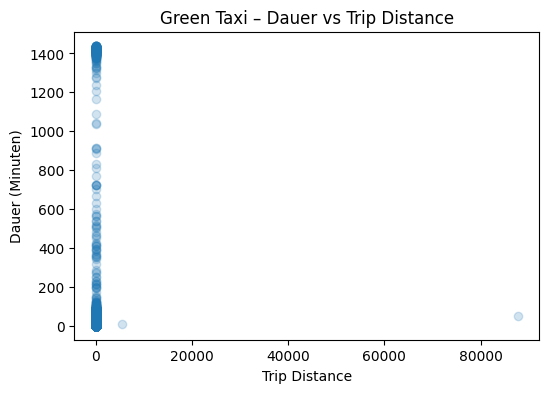

In [61]:
# Distanz vs Dauer – Scatterplot (Raw, inkl. Ausreißer)
# Untersuchung des grundsätzlichen Zusammenhangs zwischen Trip Distance 
# und Fahrtdauer unter Einbezug aller beobachteten Werte.
plt.figure(figsize=(6,4))
plt.scatter(df_green["trip_distance"], df_green["duration_min"], alpha=0.2)
plt.title("Green Taxi – Dauer vs Trip Distance")
plt.xlabel("Trip Distance")
plt.ylabel("Dauer (Minuten)")
plt.show()

Der Scatterplot zur Beziehung zwischen Fahrtdauer und Trip Distance zeigt ein stark durch Ausreißer verzerrtes Bild. Daher benutzen wir auch hier wieder den Zoom.

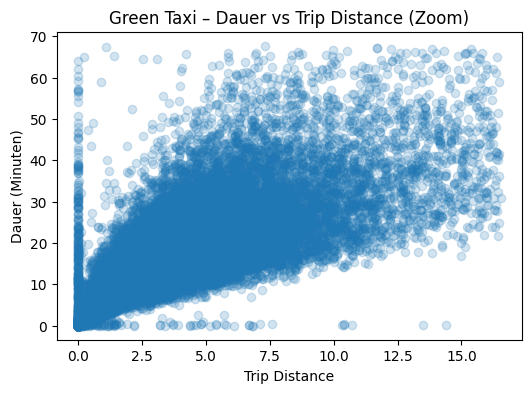

In [62]:
# Distanz vs Dauer – Zoom-Scatterplot (zur besseren Lesbarkeit)
# zur Visualisierung des plausiblen Kernbereichs

df_green_duration_scatter_zoom = df_green[
    (df_green["trip_distance"] >= 0) &
    (df_green["trip_distance"] <= td_p99) &
    (df_green["duration_min"] >= 0) &
    (df_green["duration_min"] <= dur_p99)
]

plt.figure(figsize=(6,4))
plt.scatter(
    df_green_duration_scatter_zoom["trip_distance"],
    df_green_duration_scatter_zoom["duration_min"],
    alpha=0.2
)
plt.title("Green Taxi – Dauer vs Trip Distance (Zoom)")
plt.xlabel("Trip Distance")
plt.ylabel("Dauer (Minuten)")
plt.show()

Der gezoomte Scatterplot zeigt den Zusammenhang zwischen Fahrtdistanz und Fahrtdauer im typischen Wertebereich (bis zur p99-Grenze) der Green-Taxi-Fahrten. Es ist ein klarer positiver Zusammenhang erkennbar: Mit zunehmender Distanz steigt im Durchschnitt auch die Fahrtdauer. Gleichzeitig nimmt die Streuung der Punkte bei größeren Distanzen deutlich zu, was auf unterschiedliche Verkehrsbedingungen, Routenwahl und Staus hindeutet. Besonders im Bereich kurzer Strecken ist eine hohe Punktdichte sichtbar, was die Dominanz kurzer, innerstädtischer Fahrten widerspiegelt. Die p99-Begrenzung blendet extreme Ausreißer aus und ermöglicht so eine realistische Betrachtung der typischen Fahrtsituationen, ohne dass fehlerhafte oder außergewöhnlich lange Fahrten die Analyse verzerren.
Die vertikale Linie bei einer Trip Distance von 0 entsteht durch eine große Anzahl von Fahrten, bei denen die Distanz als 0 gespeichert ist, während gleichzeitig eine positive Fahrtdauer vorliegt. In der Realität entspricht dies sehr wahrscheinlich fehlerhaften oder unvollständigen Messungen, etwa wenn das Taxameter nicht korrekt gestartet wurde, GPS-Daten fehlten oder Fahrten abgebrochen bzw. falsch geloggt wurden. Alternativ können auch Sonderfälle wie sehr kurze Fahrten oder Stornierungen mit Zeitstempel, aber ohne valide Distanzmessung enthalten sein. Da diese Beobachtungen massenhaft auftreten, bilden sie im Scatterplot eine auffällige senkrechte Punktwolke bei x = 0.

# Positivbeispiel Pickup_Datetime
## man sieht, nicht alle Spalten sind komplett fehlerhaft

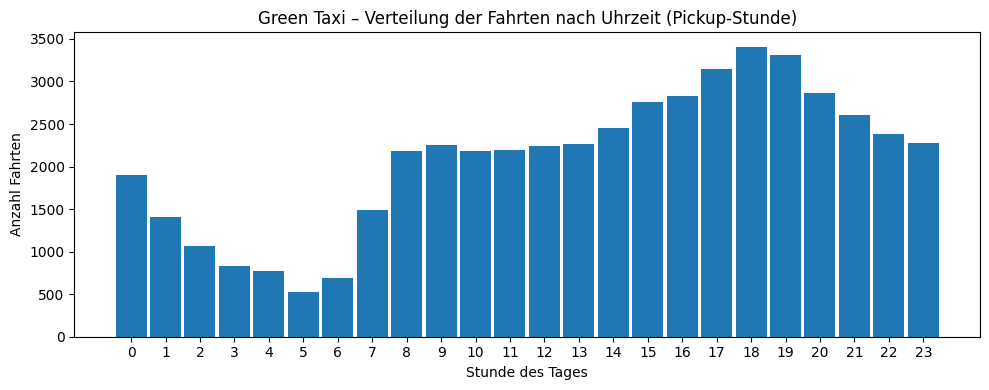

In [63]:
# Verteilung der Fahrten nach Uhrzeit (Pickup-Stunde)
# Ziel: Analyse zeitlicher Nutzungsmuster der Green-Taxi-Fahrten auf Stundenbasis.
# Die Pickup-Stunde wird aus dem Zeitstempel abgeleitet. Die Darstellung dient der Plausibilitätsprüfung
# sowie der Identifikation typischer Nachfragezeiten.
df_green["hour"] = pd.to_datetime(df_green["pickup_datetime"]).dt.hour

plt.figure(figsize=(10,4))
plt.hist(df_green["hour"], bins=range(25), align="left", rwidth=0.9)
plt.xticks(range(24))
plt.title("Green Taxi – Verteilung der Fahrten nach Uhrzeit (Pickup-Stunde)")
plt.xlabel("Stunde des Tages")
plt.ylabel("Anzahl Fahrten")
plt.tight_layout()
plt.show()

Das Histogramm zeigt die Anzahl der Green-Taxi-Fahrten pro Stunde des Tages, basierend auf der Pickup-Zeit. Dadurch werden zeitliche Nutzungsmuster und typische Nachfragephasen sichtbar.

In den frühen Morgenstunden (ca. 3–5 Uhr) ist die Anzahl der Fahrten am geringsten. Dies entspricht dem erwarteten Nachfragetief in der Nacht, wenn insgesamt wenig Personen unterwegs sind. Ab etwa 6–7 Uhr steigt die Anzahl der Fahrten deutlich an, was auf den Beginn des Berufs- und Pendlerverkehrs hindeutet.

Zwischen 8 und 10 Uhr ist ein erstes hohes Niveau erkennbar, das gut mit klassischen Arbeits- und Schulanfangszeiten übereinstimmt. Im weiteren Tagesverlauf bleibt die Nachfrage relativ stabil, mit einem leichten Rückgang zur Mittagszeit, bevor sie am späten Nachmittag und frühen Abend (ca. 16–19 Uhr) ihren Tageshöchststand erreicht. Diese Phase deckt sich mit Feierabendverkehr, Erledigungen und Freizeitaktivitäten.

In den späten Abendstunden nimmt die Anzahl der Fahrten wieder kontinuierlich ab, bleibt aber bis etwa 22–23 Uhr auf einem moderaten Niveau, was auf Abend- und Freizeitfahrten hinweist.

# Fazit

Die durchgeführte Data Exploration der Green-Taxi-Daten zeigt, dass der Datensatz in seinen grundlegenden strukturellen Merkmalen stabil aufgebaut ist, jedoch in mehreren zentralen Kennzahlen deutliche Auffälligkeiten aufweist. Insbesondere extreme Ausreißer bei Fahrtdistanz, Fahrtdauer und Fahrpreis sowie vereinzelt unplausible Werte (z. B. negative Fare Amounts oder außergewöhnlich lange Fahrten) führen zu stark verzerrten Verteilungen.

Die ungefilterten Visualisierungen verdeutlichen, dass aggregierte Kennzahlen wie Mittelwerte ohne zusätzliche Kontextualisierung nur eingeschränkt aussagekräftig sind. Durch ergänzende Zoom-Darstellungen lassen sich jedoch plausible Zusammenhänge zwischen Distanz, Dauer und Preis erkennen, wobei gleichzeitig eine hohe Streuung sichtbar bleibt.

Die zeitliche Analyse der Fahrten nach Pickup-Stunde zeigt ein konsistentes und erwartbares Nutzungsmuster über den Tagesverlauf, was auf eine grundsätzlich zuverlässige Erfassung der Zeitstempel hinweist.

Insgesamt macht die Exploration deutlich, dass die Green-Taxi-Daten für BI-Analysen nutzbar sind, sofern identifizierte Datenqualitätsprobleme transparent berücksichtigt und Kennzahlen stets im Kontext der zugrunde liegenden Verteilungen interpretiert werden. Die gewonnenen Erkenntnisse bilden eine fundierte Grundlage für nachgelagerte Analyse- und Dashboard-Schritte.